<a href="https://colab.research.google.com/github/RohithOfRivia/SMILES-Toxicity-Prediction/blob/main/backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
!pip install rdkit
!pip install -U mlxtend

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import BorderlineSMOTE

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.cluster import KMeans

from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import (GradientBoostingClassifier, 
                              HistGradientBoostingClassifier, IsolationForest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample

from sklearn.metrics import f1_score, recall_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
import time
import os
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
train_data_url = "https://raw.githubusercontent.com/RohithOfRivia/SMILES-Toxicity-Prediction/main/Data/train_II.csv"
test_data_url = "https://raw.githubusercontent.com/RohithOfRivia/SMILES-Toxicity-Prediction/main/Data/test_II.csv"

df = pd.read_csv(train_data_url)

In [3]:
#transforming each compound into their canonical SMILES format. Optional.
def canonicalSmiles(smile):
    try:
        return Chem.MolToSmiles(Chem.MolFromSmiles(smile))
    except:
        return(Chem.MolToSmiles(Chem.MolFromSmiles("[Na+].[Na+].F[Si--](F)(F)(F)(F)F")))

In [22]:
#Read data and split up the given features
class FileReadTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    #training and test data are slightly different, hence passing optional test param
    def transform(self, X, test=False):
        
        try:
          # if test == False:
            X['SMILES'] = X['Id'].apply(lambda x: x.split(';')[0])
            X['assay'] = X['Id'].apply(lambda x: x.split(';')[1])
        
        except KeyError:
            X['SMILES'] = X['x'].apply(lambda x: x.split(';')[0])
            X['assay'] = X['x'].apply(lambda x: x.split(';')[1])
          
        print("FileReadTransform done")
        
        #correct smiles for this compound found through https://www.molport.com/shop/index
        #X["SMILES"] = X["SMILES"].replace({"F[Si-2](F)(F)(F)(F)F.[Na+].[Na+]":"[Na+].[Na+].F[Si--](F)(F)(F)(F)F"})
        
        #Deleting invalid compound from the data
        X = X.loc[X.SMILES != "F[Si-2](F)(F)(F)(F)F.[Na+].[Na+]"]
        return X
    
    
class CanonicalGenerator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['SMILES'] = X['SMILES'].apply(canonicalSmiles)
        print("CanonicalGenerator done")
        return X


class Scaler(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        temp_df = X[X.columns[-208:]]
        ss = StandardScaler()
        temp_df = pd.DataFrame(ss.fit_transform(temp_df), columns = temp_df.columns[-208:])

        return pd.concat([X[X.columns[:4]], temp_df], axis=1)

    
class FingerprintGenerator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
          #tracks each unique compound and its fingerprints
          tracker = []
          fps = []
          assays = []
          unique = len(X['SMILES'].unique())
          counter = 0

          for index, columns in X[["SMILES", "assay"]].iterrows():

              #skip if already in tracker
              if columns[0] in tracker:
                  continue

              #append each unique compound and thier respective fingerprints
              else:
                  tracker.append(columns[0])
                  assays.append(columns[1])

                  mol = Chem.MolFromSmiles(columns[0])
                  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
                  fps.append(fp.ToList())

                  counter += 1

                  # print(f"compound {counter}/{unique}...

          #Combining all compounds, assays and fingerprints into one dataframe 
          cols = a = ["x" + str(i) for i in range (1, 257)]
          smiles_df = pd.DataFrame(columns=['SMILES'], data=tracker)
          fingerprints = pd.DataFrame(columns=cols, data=fps)

          df = pd.concat([smiles_df, fingerprints], axis=1)

          print("FingerprintGenerator done")
          return pd.merge(X, df, on='SMILES') 


#Feature reduction with variance threshold 
class VarianceThresh(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, thresh=.8):
      
      #Looks to columns to determine whether X is training or testing data 
      cols = X.columns
      if 'x' in cols:
        temp_df = X.drop(columns=["x", "assay", "SMILES"])
        cols = ["x", "assay", "SMILES"]
      else:
        temp_df = X.drop(columns=["Id", "Expected","assay", "SMILES"])
        cols = ["Id", "Expected","assay", "SMILES"]

      #Selecting features based on the variance threshold
      selector = VarianceThreshold(threshold=(thresh * (1 - thresh))) 
      selector.fit(temp_df)

      #This line transforms the data while keeping the column names 
      temp_df = temp_df.loc[:, selector.get_support()]

      #Attaching the ids, assays, smiles etc. that is still required for model
      return pd.concat([X[cols], temp_df], axis=1) , selector

      

## Generating descriptors

In [5]:
class DescriptorGenerator(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
        return self
    
  def transform(self, X):
    #Initializing descriptor calculator
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    #Tracking each unique compound and generating descriptors 
    tracker = []
    descriptors = []
    for compound in X['SMILES']:

      if compound in tracker:
        continue

      else:
        tracker.append(compound)

        mol = Chem.MolFromSmiles(compound)
        current_descriptors = calc.CalcDescriptors(mol)
        descriptors.append(current_descriptors)

    # Combining X, SMILES, and generated descriptors 
    df = pd.DataFrame(descriptors,columns=desc_names)
    temp_df = pd.DataFrame(tracker, columns=["SMILES"])
    df = pd.concat([df, temp_df], axis=1)

    print("DescriptorGenerator done")
    return pd.merge(X, df, on='SMILES')

In [6]:
feature_generation_pipeline = Pipeline(steps=[
    ('read', FileReadTransform()),
     ('canon', CanonicalGenerator()),
     ('fpr', FingerprintGenerator()),
     ('desc', DescriptorGenerator())
     ])

feature_selector_pipeline = Pipeline(steps=[
    ('vtr', VarianceThresh()),
     ])
df_processed = feature_generation_pipeline.fit_transform(df)
test_processed = feature_generation_pipeline.fit_transform(pd.read_csv(test_data_url))

FileReadTransform done
CanonicalGenerator done
FingerprintGenerator done
DescriptorGenerator done
FileReadTransform done
CanonicalGenerator done
FingerprintGenerator done
DescriptorGenerator done


In [7]:
df_processedV, selectors = feature_selector_pipeline.fit_transform(df_processed)
df_processedV

,Id,Expected,assay,SMILES,x2,x34,x39,x40,x50,x65,...,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
0,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1644,2,1644,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,1,0,1,0,0,...,2,0,0,0,3,0,0,2,2,0
1,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1630,2,1630,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,1,0,1,0,0,...,2,0,0,0,3,0,0,2,2,0
2,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;29,2,29,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,1,0,1,0,0,...,2,0,0,0,3,0,0,2,2,0
3,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1618,2,1618,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,1,0,1,0,0,...,2,0,0,0,3,0,0,2,2,0
4,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1638,2,1638,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,1,0,1,0,0,...,2,0,0,0,3,0,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,C1=CC=C(C=C1)NC(=S)N;1852,1,1852,NC(=S)Nc1ccccc1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
75373,CN1CN(CN(C1)C)C;2,2,2,CN1CN(C)CN(C)C1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75374,CCCCC1CCC(=O)O1;1852,1,1852,CCCCC1CCC(=O)O1,0,1,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0
75375,CCOC(=O)CCC1=CC=CC=C1;2,2,2,CCOC(=O)CCc1ccccc1,0,1,1,1,0,1,...,1,0,1,1,0,0,0,0,0,0


In [8]:
grouped = df_processed.groupby(["assay", "Expected"]).count().sort_values('Id', ascending=False)
grouped.loc[grouped['Id'] < 10]

,,Id,SMILES,x1,x2,x3,x4,x5,x6,x7,x8,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
assay,Expected,,,,,,,,,,,,,,,,,,,,,
2302,1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1625,1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1651,1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1644,1,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
1629,1,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
1639,1,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
20,1,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
14,1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1623,1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


(0.0, 110.0)

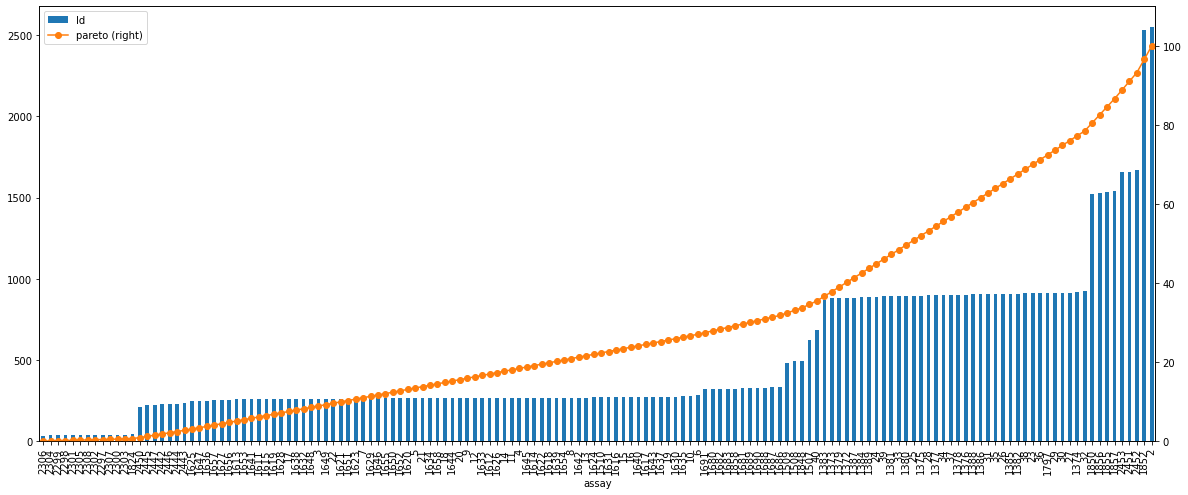

In [9]:
data = df_processed.groupby('assay').count()[['Id']].sort_values('Id')
data['pareto'] = 100 * data.Id.cumsum() / data.Id.sum()



fig, axes = plt.subplots(figsize=(20, 8))

ax1 = data.plot(use_index=True, y='Id',  kind='bar', ax=axes)
ax2 = data.plot(use_index=True, y='pareto', marker='o', color="C1", kind='line', ax=axes, secondary_y=True)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
ax2.set_ylim([0,110])

(0.0, 110.0)

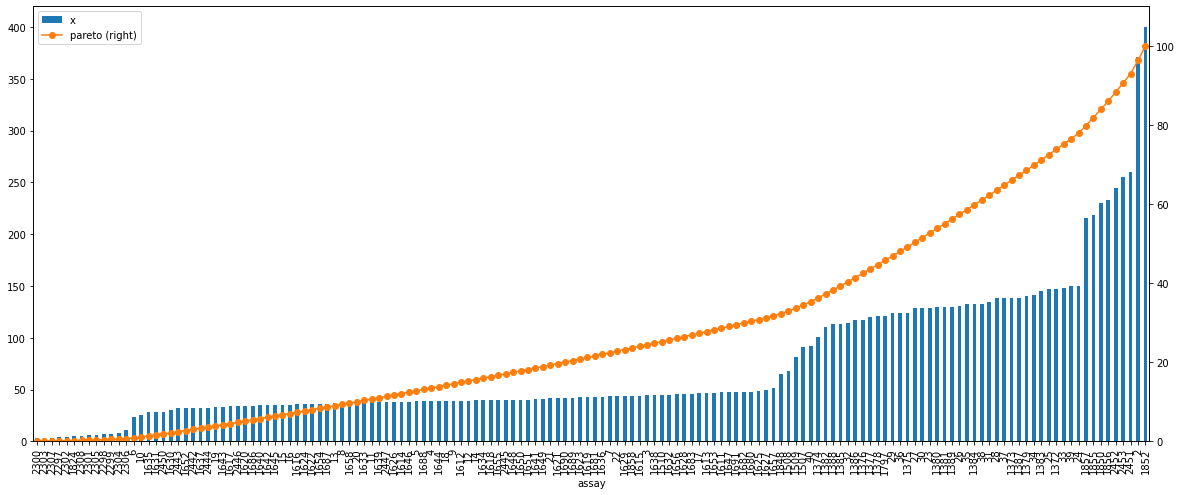

In [10]:
data = test_processed.groupby('assay').count()[['x']].sort_values('x')
data['pareto'] = 100 * data.x.cumsum() / data.x.sum()

fig, axes = plt.subplots(figsize=(20, 8))

ax1 = data.plot(use_index=True, y='x',  kind='bar', ax=axes)
ax2 = data.plot(use_index=True, y='pareto', marker='o', color="C1", kind='line', ax=axes, secondary_y=True)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
ax2.set_ylim([0,110])

In [11]:
# data = df_processed.groupby('assay').count()[['x']].sort_values('x')
# dataPositive = df_processed.groupby('assay').count()[['x']].sort_values('x')


# fig, axes = plt.subplots(figsize=(20, 8))

# ax1 = data.plot(use_index=True, y='x',  kind='bar', ax=axes)
# ax2 = data.plot(use_index=True, y='pareto', marker='o', color="C1", kind='line', ax=axes, secondary_y=True)
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
# ax2.set_ylim([0,110])

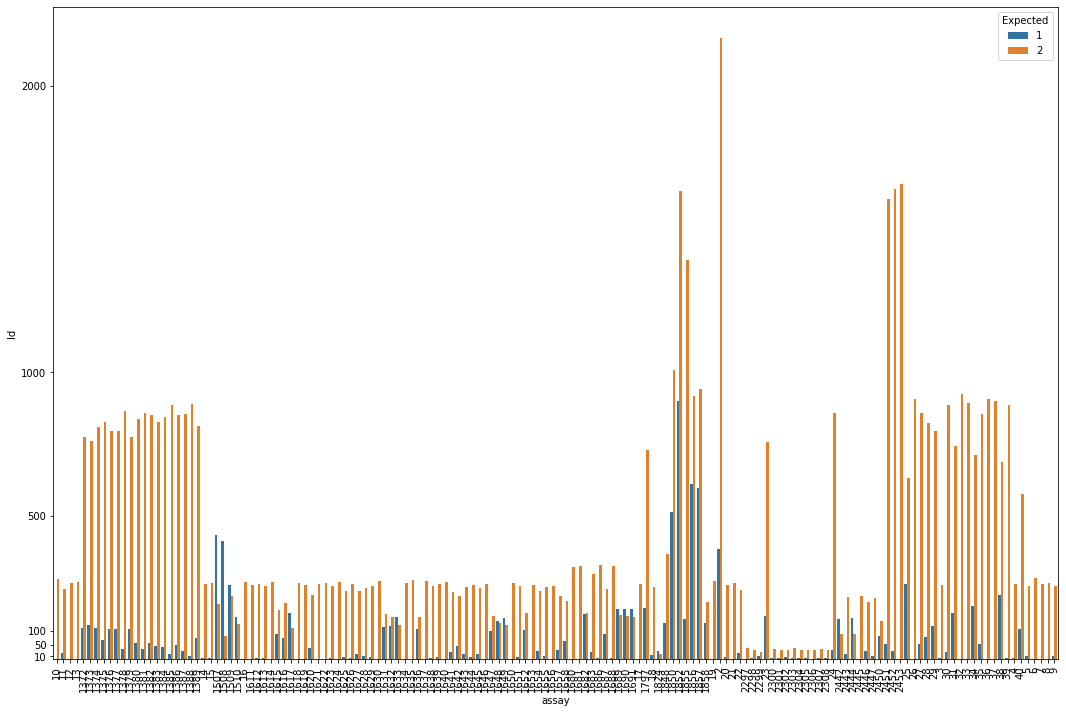

In [12]:
grouped = df_processed.groupby(['assay', 'Expected']).count()[['Id']].reset_index()
yticks = [10, 50, 100, 500, 1000, 2000]
plt.figure(figsize=(18, 12))
ax = plt.axes()
ax.set_yticks(yticks)
sns.barplot(x=grouped['assay'], y=grouped['Id'], hue=grouped["Expected"])
plt.xticks(rotation=90)

plt.show()

In [13]:
df_sample = df_processed.loc[(df_processed['assay'] == '2') | (df_processed['assay'] == '2453') | (df_processed['assay'] == '1852') | (df_processed['assay'] == '2451') ]
df_sample.groupby('assay').count()

,Id,Expected,SMILES,x1,x2,x3,x4,x5,x6,x7,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
assay,,,,,,,,,,,,,,,,,,,,,
1852,2530,2530,2530,2530,2530,2530,2530,2530,2530,2530,...,2530,2530,2530,2530,2530,2530,2530,2530,2530,2530
2,2550,2550,2550,2550,2550,2550,2550,2550,2550,2550,...,2550,2550,2550,2550,2550,2550,2550,2550,2550,2550
2451,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660,...,1660,1660,1660,1660,1660,1660,1660,1660,1660,1660
2453,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,...,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657


In [17]:
df_processed[df_processed.columns[-208:]]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.316200,-1.533785,9.316200,0.150485,0.794714,317.599,306.511,315.982463,100,0,...,0,0,0,0,0,0,0,0,0,0
1,9.316200,-1.533785,9.316200,0.150485,0.794714,317.599,306.511,315.982463,100,0,...,0,0,0,0,0,0,0,0,0,0
2,9.316200,-1.533785,9.316200,0.150485,0.794714,317.599,306.511,315.982463,100,0,...,0,0,0,0,0,0,0,0,0,0
3,9.316200,-1.533785,9.316200,0.150485,0.794714,317.599,306.511,315.982463,100,0,...,0,0,0,0,0,0,0,0,0,0
4,9.316200,-1.533785,9.316200,0.150485,0.794714,317.599,306.511,315.982463,100,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,5.244798,0.297407,5.244798,0.297407,0.596319,152.222,144.158,152.040819,52,0,...,0,0,0,0,0,0,0,0,0,0
75373,2.281250,1.087639,2.281250,1.087639,0.443158,129.207,114.087,129.126597,54,0,...,0,0,0,0,0,0,0,0,0,0
75374,10.594398,-0.012868,10.594398,0.012868,0.562255,142.198,128.086,142.099380,58,0,...,0,0,0,0,0,0,0,0,0,0
75375,10.994151,-0.119118,10.994151,0.119118,0.660429,178.231,164.119,178.099380,70,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
scaler = Scaler()
df_descriptors = scaler.fit_transform(df_processed)
df_descriptors

,Id,Expected,SMILES,assay,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1644,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1644,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
1,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1630,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1630,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
2,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;29,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,29,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
3,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1618,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1618,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
4,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1638,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1638,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,C1=CC=C(C=C1)NC(=S)N;1852,1,NC(=S)Nc1ccccc1,1852,-1.657276,0.809560,-1.657276,-0.004438,0.146656,-0.972162,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75373,CN1CN(CN(C1)C)C;2,2,CN1CN(C)CN(C)C1,2,-2.649682,1.243133,-2.649682,1.461180,-0.679339,-1.138740,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75374,CCCCC1CCC(=O)O1;1852,1,CCCCC1CCC(=O)O1,1852,0.134150,0.639323,0.134150,-0.532166,-0.037052,-1.044714,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75375,CCOC(=O)CCC1=CC=CC=C1;2,2,CCOC(=O)CCc1ccccc1,2,0.268016,0.581028,0.268016,-0.335107,0.492404,-0.783914,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539


# Feature Selection

In [41]:
ftrDict15 = {}

In [42]:
ftrDict = {'11': ['MinEStateIndex',
  'qed',
  'HeavyAtomMolWt',
  'MinPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0n',
  'Chi0v',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Kappa1',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA12',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA9',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA4',
  'SlogP_VSA5',
  'SlogP_VSA6',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'HeavyAtomCount',
  'NumAliphaticCarbocycles',
  'RingCount',
  'MolLogP',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_Ar_COO',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_Ar_OH',
  'fr_COO',
  'fr_COO2',
  'fr_C_O',
  'fr_C_O_noCOO',
  'fr_HOCCN',
  'fr_Ndealkylation1',
  'fr_Ndealkylation2',
  'fr_allylic_oxid',
  'fr_benzene',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_lactone',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_urea'],
 '1372': ['MinEStateIndex',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi3n',
  'LabuteASA',
  'PEOE_VSA4',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA5',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA6',
  'SlogP_VSA8',
  'EState_VSA8',
  'NumAliphaticCarbocycles',
  'NumAliphaticHeterocycles',
  'NumSaturatedHeterocycles',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_Ar_OH',
  'fr_Ndealkylation1',
  'fr_aniline',
  'fr_halogen',
  'fr_imidazole',
  'fr_phenol',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan'],
 '1373': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'MinAbsEStateIndex',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_MRHI',
  'Chi1v',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA8',
  'EState_VSA7',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState4',
  'VSA_EState9',
  'HeavyAtomCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumSaturatedCarbocycles',
  'RingCount',
  'fr_C_O',
  'fr_C_S',
  'fr_HOCCN',
  'fr_azo',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_nitroso',
  'fr_oxime',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1374': ['MolWt',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'MinPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi1n',
  'Chi3n',
  'Chi4v',
  'PEOE_VSA5',
  'SMR_VSA2',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA1',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA6',
  'EState_VSA9',
  'VSA_EState2',
  'VSA_EState7',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumAliphaticHeterocycles',
  'fr_Ar_N',
  'fr_C_S',
  'fr_amide',
  'fr_azide',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_ketone_Topliss',
  'fr_oxime',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1375': ['ExactMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi1v',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA10',
  'SMR_VSA2',
  'SlogP_VSA8',
  'EState_VSA11',
  'VSA_EState9',
  'NumSaturatedCarbocycles',
  'RingCount',
  'fr_Al_COO',
  'fr_Ar_NH',
  'fr_C_O',
  'fr_C_S',
  'fr_benzene',
  'fr_ketone_Topliss',
  'fr_nitrile',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1376': ['HeavyAtomMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'Chi0',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA8',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState2',
  'VSA_EState7',
  'VSA_EState8',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumSaturatedHeterocycles',
  'RingCount',
  'fr_C_S',
  'fr_HOCCN',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_isocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_morpholine',
  'fr_oxazole',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1377': ['MinEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'Chi0n',
  'Chi1n',
  'Chi3n',
  'Chi4v',
  'PEOE_VSA10',
  'SMR_VSA4',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA9',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState4',
  'VSA_EState6',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_C_S',
  'fr_aryl_methyl',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_furan',
  'fr_guanido',
  'fr_imide',
  'fr_ketone',
  'fr_piperzine',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1378': ['MaxEStateIndex',
  'MinEStateIndex',
  'qed',
  'MinPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BalabanJ',
  'Chi0',
  'Chi0v',
  'Chi1n',
  'Chi2n',
  'Chi3n',
  'Chi4n',
  'PEOE_VSA4',
  'SMR_VSA9',
  'SlogP_VSA11',
  'SlogP_VSA8',
  'VSA_EState1',
  'NumAliphaticCarbocycles',
  'fr_Ar_OH',
  'fr_Ndealkylation2',
  'fr_aldehyde',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_ester',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_phenol',
  'fr_phos_acid',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1379': ['NumValenceElectrons',
  'MinAbsPartialCharge',
  'BalabanJ',
  'Chi0n',
  'Chi0v',
  'Chi1v',
  'Chi2n',
  'PEOE_VSA10',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA1',
  'EState_VSA8',
  'VSA_EState10',
  'NumAliphaticRings',
  'NumSaturatedRings',
  'RingCount',
  'fr_C_S',
  'fr_amide',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_methoxy',
  'fr_oxime',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1380': ['MinEStateIndex',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0v',
  'Chi1n',
  'Chi1v',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA10',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA3',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA7',
  'PEOE_VSA9',
  'SlogP_VSA11',
  'SlogP_VSA8',
  'EState_VSA10',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState8',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_aldehyde',
  'fr_allylic_oxid',
  'fr_amide',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_piperdine',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1381': ['MolWt',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'Chi0v',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA10',
  'SMR_VSA2',
  'SlogP_VSA6',
  'VSA_EState9',
  'NumAliphaticCarbocycles',
  'NumAliphaticHeterocycles',
  'NumSaturatedRings',
  'RingCount',
  'fr_Ar_N',
  'fr_C_O',
  'fr_C_S',
  'fr_NH0',
  'fr_alkyl_carbamate',
  'fr_amidine',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_imidazole',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitrile',
  'fr_prisulfonamd',
  'fr_quatN',
  'fr_sulfone',
  'fr_thiophene',
  'fr_urea'],
 '1382': ['MaxEStateIndex',
  'MinEStateIndex',
  'qed',
  'MinAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'Chi0',
  'Chi0n',
  'Chi1n',
  'Chi3n',
  'PEOE_VSA13',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA7',
  'EState_VSA8',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState4',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState8',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumAliphaticHeterocycles',
  'NumSaturatedCarbocycles',
  'fr_Ar_OH',
  'fr_Ndealkylation1',
  'fr_alkyl_halide',
  'fr_aniline',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_hdrzine',
  'fr_imidazole',
  'fr_methoxy',
  'fr_nitrile',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1383': ['MinEStateIndex',
  'NumValenceElectrons',
  'MinAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BalabanJ',
  'BertzCT',
  'Chi0n',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2v',
  'Chi3v',
  'Chi4n',
  'LabuteASA',
  'PEOE_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA3',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState7',
  'VSA_EState8',
  'HeavyAtomCount',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_C_S',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_allylic_oxid',
  'fr_bicyclic',
  'fr_hdrzine',
  'fr_lactone',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1384': ['MaxEStateIndex',
  'MaxAbsEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'Chi0n',
  'Chi1n',
  'Chi1v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'Ipc',
  'Kappa1',
  'PEOE_VSA4',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA8',
  'VSA_EState1',
  'NOCount',
  'NumAliphaticHeterocycles',
  'NumAliphaticRings',
  'NumHeteroatoms',
  'NumSaturatedCarbocycles',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_ArN',
  'fr_Ar_COO',
  'fr_Ar_OH',
  'fr_COO',
  'fr_COO2',
  'fr_Ndealkylation2',
  'fr_alkyl_halide',
  'fr_aniline',
  'fr_azo',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imide',
  'fr_lactone',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1385': ['MaxEStateIndex',
  'qed',
  'HeavyAtomMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'BCUT2D_MRHI',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'HallKierAlpha',
  'Kappa1',
  'LabuteASA',
  'PEOE_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'EState_VSA4',
  'EState_VSA8',
  'NHOHCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumHDonors',
  'NumHeteroatoms',
  'NumSaturatedCarbocycles',
  'NumSaturatedRings',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_NH0',
  'fr_aniline',
  'fr_ether',
  'fr_methoxy',
  'fr_oxazole',
  'fr_piperdine',
  'fr_piperzine',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_tetrazole',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1386': ['MolWt',
  'NumValenceElectrons',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi1v',
  'Chi3n',
  'Chi4n',
  'Chi4v',
  'PEOE_VSA1',
  'PEOE_VSA5',
  'SlogP_VSA10',
  'EState_VSA4',
  'VSA_EState1',
  'NOCount',
  'NumAliphaticRings',
  'NumHeteroatoms',
  'NumSaturatedCarbocycles',
  'NumSaturatedHeterocycles',
  'MolMR',
  'fr_Ar_N',
  'fr_Ar_OH',
  'fr_C_O_noCOO',
  'fr_C_S',
  'fr_alkyl_halide',
  'fr_azo',
  'fr_epoxide',
  'fr_lactone',
  'fr_oxime',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1387': ['MaxEStateIndex',
  'MinEStateIndex',
  'qed',
  'MolWt',
  'NumValenceElectrons',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BalabanJ',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi1',
  'Chi1v',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'HallKierAlpha',
  'LabuteASA',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SlogP_VSA1',
  'SlogP_VSA12',
  'SlogP_VSA6',
  'EState_VSA6',
  'VSA_EState9',
  'NHOHCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumHAcceptors',
  'NumHDonors',
  'RingCount',
  'MolMR',
  'fr_Ar_N',
  'fr_C_O_noCOO',
  'fr_C_S',
  'fr_HOCCN',
  'fr_N_O',
  'fr_SH',
  'fr_alkyl_carbamate',
  'fr_ester',
  'fr_ether',
  'fr_furan',
  'fr_imidazole',
  'fr_methoxy',
  'fr_phos_acid',
  'fr_piperzine',
  'fr_quatN',
  'fr_sulfide',
  'fr_term_acetylene',
  'fr_thiophene'],
 '1388': ['MinAbsEStateIndex',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi3n',
  'Chi3v',
  'Chi4v',
  'HallKierAlpha',
  'Ipc',
  'PEOE_VSA13',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA6',
  'SMR_VSA8',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA5',
  'SlogP_VSA6',
  'SlogP_VSA8',
  'TPSA',
  'EState_VSA11',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA6',
  'EState_VSA8',
  'VSA_EState2',
  'VSA_EState7',
  'NOCount',
  'NumAliphaticHeterocycles',
  'NumHAcceptors',
  'fr_Ar_NH',
  'fr_C_S',
  'fr_aniline',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_piperzine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_thiazole',
  'fr_urea'],
 '1389': ['MaxPartialCharge',
  'MinAbsPartialCharge',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi1n',
  'Chi3n',
  'Chi3v',
  'Chi4v',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA5',
  'SMR_VSA7',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA8',
  'VSA_EState9',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_NH1',
  'fr_alkyl_halide',
  'fr_aniline',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_hdrzine',
  'fr_imide',
  'fr_methoxy',
  'fr_piperzine',
  'fr_prisulfonamd',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene'],
 '14': ['MinEStateIndex',
  'MinAbsEStateIndex',
  'qed',
  'MolWt',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MWHI',
  'BCUT2D_LOGPHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'Chi0n',
  'Chi1',
  'Chi1n',
  'Chi3n',
  'Chi4n',
  'Chi4v',
  'Ipc',
  'Kappa2',
  'LabuteASA',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA2',
  'PEOE_VSA3',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'PEOE_VSA9',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'EState_VSA1',
  'EState_VSA10',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState2',
  'VSA_EState4',
  'VSA_EState6',
  'VSA_EState7',
  'VSA_EState8',
  'FractionCSP3',
  'HeavyAtomCount',
  'NHOHCount',
  'NumSaturatedCarbocycles',
  'NumSaturatedHeterocycles',
  'fr_Al_OH_noTert',
  'fr_NH1',
  'fr_allylic_oxid',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_piperdine',
  'fr_piperzine',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfone',
  'fr_urea'],
 '15': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'MinAbsEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BertzCT',
  'Chi0',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'HallKierAlpha',
  'Ipc',
  'Kappa1',
  'Kappa2',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA13',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA4',
  'SlogP_VSA5',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA1',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA5',
  'EState_VSA7',
  'EState_VSA8',
  'VSA_EState1',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState6',
  'VSA_EState9',
  'NHOHCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAliphaticHeterocycles',
  'NumAliphaticRings',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumHDonors',
  'NumHeteroatoms',
  'NumSaturatedCarbocycles',
  'NumSaturatedHeterocycles',
  'NumSaturatedRings',
  'fr_Al_OH_noTert',
  'fr_Ar_OH',
  'fr_C_S',
  'fr_HOCCN',
  'fr_Imine',
  'fr_NH0',
  'fr_NH1',
  'fr_NH2',
  'fr_N_O',
  'fr_Ndealkylation1',
  'fr_Ndealkylation2',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_aldehyde',
  'fr_alkyl_carbamate',
  'fr_allylic_oxid',
  'fr_amide',
  'fr_amidine',
  'fr_aniline',
  'fr_aryl_methyl',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzene',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_furan',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzone',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_lactone',
  'fr_nitrile',
  'fr_nitro_arom_nonortho',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_prisulfonamd',
  'fr_quatN',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1507': ['MaxEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'HeavyAtomMolWt',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_CHGHI',
  'BCUT2D_LOGPHI',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi3n',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA12',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA4',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'TPSA',
  'EState_VSA10',
  'EState_VSA5',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState7',
  'VSA_EState8',
  'VSA_EState9',
  'FractionCSP3',
  'HeavyAtomCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAliphaticRings',
  'NumAromaticCarbocycles',
  'NumHAcceptors',
  'NumHeteroatoms',
  'NumRotatableBonds',
  'NumSaturatedHeterocycles',
  'MolLogP',
  'fr_ArN',
  'fr_Ar_COO',
  'fr_Ar_OH',
  'fr_HOCCN',
  'fr_NH1',
  'fr_SH',
  'fr_alkyl_halide',
  'fr_benzene',
  'fr_bicyclic',
  'fr_guanido',
  'fr_imidazole',
  'fr_isocyan',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_piperdine',
  'fr_piperzine',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_sulfide',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_urea'],
 '1508': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MinPartialCharge',
  'BCUT2D_CHGHI',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'Chi1',
  'Chi2v',
  'HallKierAlpha',
  'Kappa2',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA14',
  'PEOE_VSA4',
  'PEOE_VSA6',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState6',
  'VSA_EState9',
  'FractionCSP3',
  'HeavyAtomCount',
  'NumSaturatedHeterocycles',
  'fr_Ar_N',
  'fr_aldehyde',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_imide',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_piperdine',
  'fr_piperzine',
  'fr_prisulfonamd']}

In [43]:
ftrDict2 = {'11': ['MinEStateIndex',
  'MinAbsEStateIndex',
  'qed',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'MinPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4v',
  'Kappa1',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA4',
  'SlogP_VSA6',
  'TPSA',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA7',
  'EState_VSA8',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState7',
  'NumSaturatedCarbocycles',
  'RingCount',
  'MolLogP',
  'MolMR',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_Ar_COO',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_COO',
  'fr_COO2',
  'fr_C_O',
  'fr_C_O_noCOO',
  'fr_C_S',
  'fr_HOCCN',
  'fr_Ndealkylation1',
  'fr_Nhpyrrole',
  'fr_allylic_oxid',
  'fr_benzene',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_lactone',
  'fr_morpholine',
  'fr_nitrile',
  'fr_oxime',
  'fr_urea'],
 '1372': ['MinEStateIndex',
  'MinAbsEStateIndex',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MWHI',
  'BCUT2D_LOGPLOW',
  'BertzCT',
  'Chi0n',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi4n',
  'Chi4v',
  'HallKierAlpha',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SlogP_VSA6',
  'SlogP_VSA8',
  'EState_VSA7',
  'EState_VSA8',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'HeavyAtomCount',
  'NumAromaticCarbocycles',
  'fr_Al_OH',
  'fr_Ar_N',
  'fr_Ar_OH',
  'fr_C_S',
  'fr_HOCCN',
  'fr_Imine',
  'fr_allylic_oxid',
  'fr_aniline',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_morpholine',
  'fr_phenol',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan'],
 '1373': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'MinAbsEStateIndex',
  'HeavyAtomMolWt',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'BalabanJ',
  'BertzCT',
  'Chi1v',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA8',
  'VSA_EState2',
  'VSA_EState6',
  'HeavyAtomCount',
  'NumAliphaticCarbocycles',
  'fr_Al_OH_noTert',
  'fr_Ar_N',
  'fr_C_S',
  'fr_HOCCN',
  'fr_aryl_methyl',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1374': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_MRHI',
  'Chi1n',
  'Chi1v',
  'Chi3n',
  'PEOE_VSA5',
  'SMR_VSA2',
  'SlogP_VSA7',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA1',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA6',
  'VSA_EState2',
  'VSA_EState7',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumAliphaticHeterocycles',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Ar_COO',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_COO2',
  'fr_C_S',
  'fr_amide',
  'fr_azide',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_hdrzine',
  'fr_imide',
  'fr_methoxy',
  'fr_oxazole',
  'fr_oxime',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1375': ['MinEStateIndex',
  'MolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi1',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'LabuteASA',
  'PEOE_VSA10',
  'SMR_VSA2',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'EState_VSA11',
  'VSA_EState9',
  'NumSaturatedCarbocycles',
  'fr_Ar_N',
  'fr_C_S',
  'fr_benzene',
  'fr_ketone_Topliss',
  'fr_nitrile',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1376': ['MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'MaxPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi4n',
  'Chi4v',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SlogP_VSA8',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState2',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumSaturatedHeterocycles',
  'RingCount',
  'fr_C_S',
  'fr_HOCCN',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_morpholine',
  'fr_oxazole',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1377': ['MinEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi1',
  'Chi4n',
  'LabuteASA',
  'PEOE_VSA10',
  'SMR_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA3',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA8',
  'VSA_EState10',
  'VSA_EState6',
  'NumAliphaticHeterocycles',
  'NumAliphaticRings',
  'NumSaturatedRings',
  'RingCount',
  'fr_C_S',
  'fr_aryl_methyl',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_imide',
  'fr_ketone_Topliss',
  'fr_piperzine',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1378': ['MinEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'MolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BalabanJ',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi1n',
  'Chi2n',
  'Chi3n',
  'Chi4n',
  'PEOE_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA8',
  'VSA_EState1',
  'VSA_EState7',
  'NHOHCount',
  'NumAromaticCarbocycles',
  'fr_Ar_OH',
  'fr_Ndealkylation1',
  'fr_Ndealkylation2',
  'fr_aldehyde',
  'fr_alkyl_carbamate',
  'fr_allylic_oxid',
  'fr_ester',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_phenol',
  'fr_phos_acid',
  'fr_sulfonamd'],
 '1379': ['MaxEStateIndex',
  'MaxAbsEStateIndex',
  'MinAbsEStateIndex',
  'qed',
  'MolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinAbsPartialCharge',
  'BertzCT',
  'Chi1n',
  'Chi3n',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA3',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA1',
  'EState_VSA10',
  'EState_VSA8',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState4',
  'VSA_EState6',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_HOCCN',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_allylic_oxid',
  'fr_amide',
  'fr_bicyclic',
  'fr_epoxide',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_oxime',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_thiophene'],
 '1380': ['MaxEStateIndex',
  'MaxAbsEStateIndex',
  'MinAbsEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MaxAbsPartialCharge',
  'BCUT2D_MWHI',
  'BCUT2D_LOGPLOW',
  'BertzCT',
  'Chi2n',
  'Chi3n',
  'Chi3v',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA3',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA7',
  'PEOE_VSA9',
  'SMR_VSA2',
  'SlogP_VSA8',
  'EState_VSA8',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_C_S',
  'fr_aldehyde',
  'fr_amide',
  'fr_amidine',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_piperdine',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_term_acetylene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1381': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MinAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi2v',
  'Chi3v',
  'Chi4n',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'SMR_VSA2',
  'SlogP_VSA6',
  'EState_VSA8',
  'NumAliphaticRings',
  'NumSaturatedRings',
  'RingCount',
  'fr_Al_OH',
  'fr_Ar_N',
  'fr_C_O_noCOO',
  'fr_C_S',
  'fr_HOCCN',
  'fr_N_O',
  'fr_SH',
  'fr_alkyl_carbamate',
  'fr_allylic_oxid',
  'fr_bicyclic',
  'fr_ketone_Topliss',
  'fr_methoxy',
  'fr_nitrile',
  'fr_prisulfonamd',
  'fr_quatN',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene'],
 '1382': ['MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'MinAbsPartialCharge',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'Chi1n',
  'Chi3n',
  'PEOE_VSA13',
  'PEOE_VSA4',
  'SMR_VSA2',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA9',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState4',
  'VSA_EState6',
  'VSA_EState8',
  'HeavyAtomCount',
  'NumAromaticCarbocycles',
  'fr_Ar_OH',
  'fr_Ndealkylation1',
  'fr_alkyl_halide',
  'fr_amide',
  'fr_amidine',
  'fr_bicyclic',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_furan',
  'fr_guanido',
  'fr_lactone',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxazole',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1383': ['MinEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'MinAbsPartialCharge',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BertzCT',
  'Chi0',
  'Chi0n',
  'Chi0v',
  'Chi1n',
  'Chi3n',
  'PEOE_VSA1',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA3',
  'PEOE_VSA5',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'SMR_VSA1',
  'SMR_VSA3',
  'SMR_VSA4',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'EState_VSA3',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState4',
  'VSA_EState6',
  'NumAliphaticCarbocycles',
  'RingCount',
  'fr_C_S',
  'fr_HOCCN',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_allylic_oxid',
  'fr_bicyclic',
  'fr_hdrzine',
  'fr_lactone',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1384': ['MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MinPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4v',
  'PEOE_VSA4',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA8',
  'VSA_EState1',
  'NumSaturatedCarbocycles',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_ArN',
  'fr_Ar_COO',
  'fr_Ar_OH',
  'fr_COO',
  'fr_COO2',
  'fr_NH2',
  'fr_Ndealkylation1',
  'fr_alkyl_halide',
  'fr_amidine',
  'fr_aniline',
  'fr_azo',
  'fr_bicyclic',
  'fr_furan',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1385': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'MolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MRHI',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'HallKierAlpha',
  'Kappa1',
  'Kappa2',
  'Kappa3',
  'PEOE_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'EState_VSA4',
  'VSA_EState9',
  'NHOHCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumHeteroatoms',
  'NumSaturatedHeterocycles',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_C_S',
  'fr_Imine',
  'fr_Ndealkylation1',
  'fr_aniline',
  'fr_ether',
  'fr_methoxy',
  'fr_phenol',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_sulfonamd',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1386': ['MinEStateIndex',
  'MolWt',
  'ExactMolWt',
  'NumRadicalElectrons',
  'MinPartialCharge',
  'FpDensityMorgan2',
  'BCUT2D_MWHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPLOW',
  'Chi0n',
  'Chi0v',
  'Chi1n',
  'Chi2v',
  'Chi3n',
  'Chi4v',
  'Kappa1',
  'PEOE_VSA5',
  'SlogP_VSA10',
  'EState_VSA4',
  'EState_VSA9',
  'NumAliphaticCarbocycles',
  'NumSaturatedRings',
  'fr_ArN',
  'fr_HOCCN',
  'fr_N_O',
  'fr_SH',
  'fr_alkyl_carbamate',
  'fr_alkyl_halide',
  'fr_aniline',
  'fr_lactone',
  'fr_oxime',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfonamd',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_unbrch_alkane',
  'fr_urea'],
 '1387': ['MinEStateIndex',
  'qed',
  'MaxPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_MRHI',
  'BalabanJ',
  'BertzCT',
  'Chi0n',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4v',
  'Kappa1',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA6',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA12',
  'SlogP_VSA6',
  'VSA_EState9',
  'NOCount',
  'NumAliphaticHeterocycles',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumHAcceptors',
  'NumHDonors',
  'NumRotatableBonds',
  'RingCount',
  'MolLogP',
  'MolMR',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_Ar_COO',
  'fr_Ar_N',
  'fr_C_O',
  'fr_C_S',
  'fr_Imine',
  'fr_Ndealkylation1',
  'fr_aniline',
  'fr_ester',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_imidazole',
  'fr_lactone',
  'fr_methoxy',
  'fr_phos_acid',
  'fr_piperzine',
  'fr_prisulfonamd',
  'fr_quatN',
  'fr_sulfide',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiazole',
  'fr_thiophene'],
 '1388': ['MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'BCUT2D_MRHI',
  'Chi1v',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA13',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA3',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA8',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA5',
  'SlogP_VSA6',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA11',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA6',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState7',
  'VSA_EState8',
  'VSA_EState9',
  'FractionCSP3',
  'HeavyAtomCount',
  'NOCount',
  'NumAliphaticHeterocycles',
  'NumHAcceptors',
  'fr_Ar_NH',
  'fr_C_S',
  'fr_Imine',
  'fr_Ndealkylation1',
  'fr_aniline',
  'fr_furan',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_piperzine',
  'fr_priamide',
  'fr_pyridine',
  'fr_sulfide',
  'fr_thiazole',
  'fr_urea'],
 '1389': ['MaxEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'MaxPartialCharge',
  'MinAbsPartialCharge',
  'BalabanJ',
  'BertzCT',
  'Chi1n',
  'Chi3n',
  'Chi4v',
  'PEOE_VSA5',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA2',
  'SlogP_VSA8',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState4',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState7',
  'VSA_EState9',
  'HeavyAtomCount',
  'NumSaturatedHeterocycles',
  'RingCount',
  'fr_NH1',
  'fr_alkyl_halide',
  'fr_aniline',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_lactam',
  'fr_methoxy',
  'fr_oxime',
  'fr_prisulfonamd',
  'fr_term_acetylene',
  'fr_thiophene'],
 '14': ['MaxEStateIndex',
  'MinEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MinAbsPartialCharge',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_CHGHI',
  'BCUT2D_CHGLO',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi2v',
  'Chi3n',
  'Kappa2',
  'PEOE_VSA1',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA4',
  'SlogP_VSA5',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA2',
  'EState_VSA3',
  'EState_VSA4',
  'EState_VSA5',
  'EState_VSA6',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState8',
  'HeavyAtomCount',
  'NHOHCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumHeteroatoms',
  'NumRotatableBonds',
  'NumSaturatedCarbocycles',
  'NumSaturatedHeterocycles',
  'fr_Al_OH',
  'fr_COO',
  'fr_NH1',
  'fr_allylic_oxid',
  'fr_amide',
  'fr_amidine',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzene',
  'fr_benzodiazepine',
  'fr_bicyclic',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_ester',
  'fr_ether',
  'fr_furan',
  'fr_guanido',
  'fr_hdrzine',
  'fr_hdrzone',
  'fr_imidazole',
  'fr_imide',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactam',
  'fr_lactone',
  'fr_methoxy',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_nitroso',
  'fr_oxazole',
  'fr_oxime',
  'fr_phenol',
  'fr_phenol_noOrthoHbond',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_piperdine',
  'fr_piperzine',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfide'],
 '15': ['MinEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'MolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxPartialCharge',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'BCUT2D_MWHI',
  'BCUT2D_CHGHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi3v',
  'Chi4n',
  'HallKierAlpha',
  'Kappa1',
  'Kappa2',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA2',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA12',
  'SlogP_VSA3',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'TPSA',
  'EState_VSA1',
  'EState_VSA10',
  'EState_VSA2',
  'EState_VSA5',
  'EState_VSA6',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState5',
  'VSA_EState9',
  'HeavyAtomCount',
  'NHOHCount',
  'NumAliphaticCarbocycles',
  'NumAliphaticHeterocycles',
  'NumAliphaticRings',
  'NumAromaticCarbocycles',
  'NumAromaticHeterocycles',
  'NumAromaticRings',
  'NumHAcceptors',
  'NumHDonors',
  'NumSaturatedCarbocycles',
  'NumSaturatedHeterocycles',
  'NumSaturatedRings',
  'MolLogP',
  'MolMR',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_ArN',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_Ar_OH',
  'fr_C_O_noCOO',
  'fr_C_S',
  'fr_HOCCN',
  'fr_Imine',
  'fr_NH0',
  'fr_NH1',
  'fr_NH2',
  'fr_N_O',
  'fr_Ndealkylation1',
  'fr_Ndealkylation2',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_aldehyde',
  'fr_alkyl_carbamate',
  'fr_allylic_oxid',
  'fr_benzene',
  'fr_ester',
  'fr_halogen',
  'fr_imide',
  'fr_ketone',
  'fr_nitrile',
  'fr_phenol',
  'fr_sulfide',
  'fr_sulfonamd',
  'fr_urea'],
 '1507': ['qed',
  'ExactMolWt',
  'FpDensityMorgan1',
  'BCUT2D_LOGPHI',
  'BCUT2D_LOGPLOW',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'HallKierAlpha',
  'Ipc',
  'Kappa1',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA13',
  'PEOE_VSA2',
  'PEOE_VSA3',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA8',
  'PEOE_VSA9',
  'SMR_VSA1',
  'SMR_VSA10',
  'SMR_VSA2',
  'SMR_VSA3',
  'SMR_VSA4',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA2',
  'SlogP_VSA4',
  'SlogP_VSA6',
  'SlogP_VSA7',
  'TPSA',
  'EState_VSA10',
  'EState_VSA5',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState4',
  'VSA_EState5',
  'VSA_EState6',
  'VSA_EState7',
  'VSA_EState8',
  'VSA_EState9',
  'FractionCSP3',
  'HeavyAtomCount',
  'NOCount',
  'NumAliphaticRings',
  'NumAromaticCarbocycles',
  'NumHAcceptors',
  'NumHeteroatoms',
  'MolLogP',
  'fr_Al_COO',
  'fr_Al_OH',
  'fr_Al_OH_noTert',
  'fr_ArN',
  'fr_Ar_OH',
  'fr_COO',
  'fr_NH1',
  'fr_alkyl_halide',
  'fr_benzene',
  'fr_bicyclic',
  'fr_guanido',
  'fr_lactone',
  'fr_nitrile',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_oxazole',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_phenol',
  'fr_phos_acid',
  'fr_phos_ester',
  'fr_piperdine',
  'fr_piperzine',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_sulfide',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiocyan',
  'fr_thiophene',
  'fr_urea'],
 '1508': ['MaxEStateIndex',
  'MaxAbsEStateIndex',
  'qed',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MinPartialCharge',
  'MaxAbsPartialCharge',
  'MinAbsPartialCharge',
  'FpDensityMorgan1',
  'BCUT2D_CHGHI',
  'BCUT2D_LOGPHI',
  'Chi1',
  'Chi1n',
  'Chi1v',
  'Chi2n',
  'Chi2v',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Chi4v',
  'HallKierAlpha',
  'Ipc',
  'Kappa1',
  'Kappa2',
  'Kappa3',
  'LabuteASA',
  'PEOE_VSA1',
  'PEOE_VSA10',
  'PEOE_VSA11',
  'PEOE_VSA12',
  'PEOE_VSA13',
  'PEOE_VSA14',
  'PEOE_VSA2',
  'PEOE_VSA3',
  'PEOE_VSA6',
  'PEOE_VSA9',
  'SMR_VSA3',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA11',
  'SlogP_VSA2',
  'SlogP_VSA8',
  'EState_VSA7',
  'EState_VSA8',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState4',
  'VSA_EState5',
  'VSA_EState7',
  'VSA_EState8',
  'VSA_EState9',
  'FractionCSP3',
  'HeavyAtomCount',
  'NumSaturatedHeterocycles',
  'fr_Ar_N',
  'fr_aldehyde',
  'fr_azide',
  'fr_azo',
  'fr_barbitur',
  'fr_benzodiazepine',
  'fr_diazo',
  'fr_dihydropyridine',
  'fr_epoxide',
  'fr_imide',
  'fr_nitro_arom',
  'fr_prisulfonamd'],
 '1509': ['MaxEStateIndex',
  'MinEStateIndex',
  'MolWt',
  'HeavyAtomMolWt',
  'ExactMolWt',
  'NumValenceElectrons',
  'NumRadicalElectrons',
  'MaxAbsPartialCharge',
  'FpDensityMorgan1',
  'FpDensityMorgan2',
  'FpDensityMorgan3',
  'BCUT2D_MWHI',
  'BCUT2D_MWLOW',
  'BCUT2D_LOGPHI',
  'BCUT2D_MRHI',
  'BCUT2D_MRLOW',
  'BalabanJ',
  'BertzCT',
  'Chi0n',
  'Chi0v',
  'Chi1',
  'Chi1n',
  'Chi2n',
  'Chi3n',
  'Chi3v',
  'Chi4n',
  'Kappa1',
  'Kappa2',
  'LabuteASA',
  'PEOE_VSA3',
  'PEOE_VSA4',
  'PEOE_VSA5',
  'PEOE_VSA6',
  'PEOE_VSA7',
  'PEOE_VSA9',
  'SMR_VSA10',
  'SMR_VSA5',
  'SMR_VSA6',
  'SMR_VSA7',
  'SMR_VSA8',
  'SMR_VSA9',
  'SlogP_VSA1',
  'SlogP_VSA10',
  'SlogP_VSA11',
  'SlogP_VSA2',
  'SlogP_VSA3',
  'SlogP_VSA5',
  'SlogP_VSA7',
  'SlogP_VSA8',
  'SlogP_VSA9',
  'TPSA',
  'EState_VSA10',
  'EState_VSA11',
  'EState_VSA5',
  'EState_VSA6',
  'EState_VSA9',
  'VSA_EState1',
  'VSA_EState10',
  'VSA_EState2',
  'VSA_EState3',
  'VSA_EState4',
  'VSA_EState5',
  'FractionCSP3',
  'HeavyAtomCount',
  'NOCount',
  'NumAliphaticCarbocycles',
  'NumAromaticRings',
  'NumRotatableBonds',
  'NumSaturatedRings',
  'MolLogP',
  'MolMR',
  'fr_Ar_COO',
  'fr_Ar_N',
  'fr_Ar_NH',
  'fr_C_O_noCOO',
  'fr_HOCCN',
  'fr_NH1',
  'fr_NH2',
  'fr_N_O',
  'fr_Ndealkylation2',
  'fr_Nhpyrrole',
  'fr_SH',
  'fr_aldehyde',
  'fr_alkyl_carbamate',
  'fr_allylic_oxid',
  'fr_amide',
  'fr_benzene',
  'fr_furan',
  'fr_guanido',
  'fr_halogen',
  'fr_hdrzone',
  'fr_isocyan',
  'fr_isothiocyan',
  'fr_ketone',
  'fr_lactam',
  'fr_morpholine',
  'fr_nitrile',
  'fr_nitro_arom',
  'fr_oxime',
  'fr_para_hydroxylation',
  'fr_piperdine',
  'fr_piperzine',
  'fr_priamide',
  'fr_prisulfonamd',
  'fr_pyridine',
  'fr_quatN',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_tetrazole',
  'fr_thiophene',
  'fr_urea']}

# Feature Selection function

In [48]:
class FeatureSelector(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
        return self
    
  def transform(self, X):
    
    master_best_features = {}
    assays = X.groupby('assay').count().index

    for assay in assays:
      if assay in ftrDict.keys():
        print("already finished assay "+ assay)
        continue

      currentAssay = X.loc[X['assay'] == str(assay)]
    
      currentAssay = currentAssay.drop(columns=['assay', 'Id', 'SMILES'])
      
      #Initializing some variables to store the best features and also dropping columns/rows with nan values
      print("Assay: " + assay)
      counter = 0
      best_features = []
      df_cleaned = currentAssay.dropna()
      cols = df_cleaned.columns.tolist()
      cols.remove("Expected")
      exp = df_cleaned['Expected']
        
      while (counter<=len(cols)):
        try:
          lr = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1, max_iter=500)
          lr.fit(df_cleaned[cols[counter:counter+15]], exp)
        

          sf = SFS(lr, k_features='best', forward=False, n_jobs=-1)
          sf.fit(df_cleaned[cols[counter:counter+15]], exp)
          
          best_features.append(list(sf.k_feature_names_))
          # print(f"searched through {counter + 15} columns for assay {assay}...\n")

          counter += 15
        
          

          master_best_features[assay] = np.concatenate(best_features).tolist()
          ftrDict[assay] = np.concatenate(best_features).tolist()
        except ValueError:
          print(f"\nOnly one class for assay {assay}.\n")
          counter = len(cols) + 1
          pass
          break 

    return master_best_features

In [58]:
# class FeatureSelector2(BaseEstimator, TransformerMixin):

#   def fit(self, X, y=None):
#         return self
    
#   def transform(self, X):
    
#     master_best_features = {}
#     assays = X.groupby('assay').count().index

#     for assay in assays:
#       if assay in ftrDict15.keys():
#         print("already finished assay "+ assay)
#         continue

#       currentAssay = X.loc[X['assay'] == str(assay)]
    
#       currentAssay = currentAssay.drop(columns=['assay', 'Id', 'SMILES'])
      
#       #Initializing some variables to store the best features and also dropping columns/rows with nan values
#       print("Assay: " + assay)
#       counter = 0
#       best_features = []
#       df_cleaned = currentAssay.dropna()
#       cols = df_cleaned.columns.tolist()
#       cols.remove("Expected")
#       exp = df_cleaned['Expected']
        
#       try:
#         lr = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1, max_iter=500)
#         lr.fit(df_cleaned, exp)
      

#         sf = SFS(lr, k_features=20, forward=False, n_jobs=-1)
#         sf.fit(df_cleaned, exp)
        
#         best_features.append(list(sf.k_feature_names_))
#         # print(f"searched through {counter + 15} columns for assay {assay}...\n")


#         master_best_features[assay] = np.concatenate(best_features).tolist()
#         ftrDict15[assay] = np.concatenate(best_features).tolist()
#       except ValueError:
#         print(f"\nOnly one class for assay {assay}.\n")
#         counter = len(cols) + 1
#         pass
#         continue 

#     return master_best_features

In [54]:
# desc_df_processed = df_processed[df_processed.columns[260:]]
# desc_df_processed = pd.concat([df_processed[df_processed.columns[:4]], desc_df_processed], axis=1)

In [57]:
ftr = FeatureSelector2()

feature_dict = ftr.fit_transform(df_descriptors.loc[df_descriptors['assay'] == '2'])

Assay: 2



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: ignored

In [51]:
feature_dict

{}

In [32]:
len(ftrDict['1383'])

56

In [28]:
len(df_processed.columns)

468

In [24]:
ftr = FeatureSelector()

feature_dict = ftr.fit_transform(df_processed)

Assay: 10

Only one class for assay 10.

Assay: 11
Assay: 12

Only one class for assay 12.

Assay: 13

Only one class for assay 13.

Assay: 1372
Assay: 1373
Assay: 1374
Assay: 1375
Assay: 1376
Assay: 1377
Assay: 1378
Assay: 1379
Assay: 1380
Assay: 1381
Assay: 1382
Assay: 1383



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: ignored

In [56]:
ftrDict15

{}

In [ ]:
   
   # df_sample.loc[(df_sample['assay'] == '2') | (df_sample['assay'] == '1852')].groupby('assay').count()

In [ ]:
np.concatenate(feature_dict['2452'])

Feature selection embedded

In [ ]:
class FeatureSelector2(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
        return self
    
  def transform(self, X):
    
    master_best_features = {}
    assays = X.groupby('assay').count().index

    for assay in assays:
      if assay in ftrDict15.keys():
        print("already finished assay "+ assay)
        continue

      currentAssay = X.loc[X['assay'] == str(assay)]
    
      currentAssay = currentAssay.drop(columns=['assay', 'Id', 'SMILES'])
      
      #Initializing some variables to store the best features and also dropping columns/rows with nan values
      print("Assay: " + assay)
      counter = 0
      best_features = []
      df_cleaned = currentAssay.dropna()
      cols = df_cleaned.columns.tolist()
      cols.remove("Expected")
      exp = df_cleaned['Expected']
        
      try:
        lr = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1, max_iter=500)
        lr.fit(df_cleaned, exp)
      

        sf = SFS(lr, k_features=20, forward=False, n_jobs=-1)
        sf.fit(df_cleaned, exp)
        
        best_features.append(list(sf.k_feature_names_))
        # print(f"searched through {counter + 15} columns for assay {assay}...\n")


        master_best_features[assay] = np.concatenate(best_features).tolist()
        ftrDict15[assay] = np.concatenate(best_features).tolist()
      except ValueError:
        print(f"\nOnly one class for assay {assay}.\n")
        counter = len(cols) + 1
        pass
        continue 

    return master_best_features



In [63]:
sample = df_descriptors.loc[df_descriptors['assay'] == '2'].drop(columns=['Id', 'SMILES', 'assay'])
sample = sample.dropna()
x = sample.drop(columns='Expected')
y = sample['Expected']

model = RandomForestClassifier().fit(x, y)
important_features = pd.DataFrame((model.feature_importances_*100), index = x.columns, columns=['importance']).sort_values('importance', ascending=False)
#Same can be done with ExtraTree too.

In [74]:
important_features[:46]

,importance
MinPartialCharge,2.717424
MaxAbsPartialCharge,2.353861
BCUT2D_MWLOW,1.634752
MaxAbsEStateIndex,1.548370
qed,1.396179
VSA_EState3,1.382398
BCUT2D_CHGLO,1.357252
BCUT2D_LOGPLOW,1.322242
PEOE_VSA7,1.319291
Chi3v,1.257326


In [78]:
X1 = x[list(x.columns)]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_info['Column'] = x.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,inf,MaxEStateIndex
53,inf,PEOE_VSA4
78,inf,SlogP_VSA7
77,inf,SlogP_VSA6
76,inf,SlogP_VSA5
...,...,...
67,NaN,SMR_VSA8
80,NaN,SlogP_VSA9
156,NaN,fr_barbitur
160,NaN,fr_diazo


XGBoost

In [144]:
sample['Expected'].map({2:0, 1:1}).value_counts()

0    2042
1     360
Name: Expected, dtype: int64

In [88]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax',
                    silent=True, nthread=1)

In [89]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [90]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x,y), verbose=3, random_state=1001 )

# Here we go

random_search.fit(x, y)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


ValueError: ignored

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [114]:
print(X_train.columns.size)
# Correlation-based feature selection
corr_matrix = pd.DataFrame(X_train).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

#X_train = np.delete(X_train.values, to_drop, axis=1)
#X_test = np.delete(X_test.values, to_drop, axis=1)
print(to_drop)

X_train = X_train.drop(columns=to_drop)
X_test.drop(columns=to_drop)


208
['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'LabuteASA', 'SMR_VSA1', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA5', 'SlogP_VSA6', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'VSA_EState1', 'VSA_EState10', 'VSA_EState3', 'VSA_EState6', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_N', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene
75366,0.048874,0.384548,-0.550965,-0.416597,0.067880,-0.069402,-0.118493,0.112716,0.686513,3.736396,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
43727,0.355554,0.124172,-0.362398,-0.911141,-0.087856,-0.069402,0.013783,-0.402193,-0.374238,-0.731606,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
64635,0.634702,-0.713251,-0.314437,0.243061,0.222841,-0.069402,-0.155511,0.674185,0.128223,0.423083,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
62735,0.105299,0.252196,-0.106104,0.223608,0.037496,-0.069402,-0.095611,0.552138,1.924056,0.604607,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,10.419193,-0.05484,-0.084309
33013,-0.519182,0.851061,0.135848,-0.906869,-0.319132,-0.069402,-1.005778,0.116735,-2.058960,-0.752205,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3393,0.516424,0.390134,-0.130256,0.795355,1.121928,-0.069402,-0.061729,-0.750176,0.139029,0.369898,...,-0.277465,-0.105196,3.608595,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
72144,0.286914,0.577192,-0.322142,0.537190,-0.537091,-0.069402,0.002262,-0.397700,0.686513,-0.731561,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
71990,0.237326,0.429178,0.178197,-0.436307,-0.885757,-0.069402,0.138033,-0.422452,0.686513,-0.732935,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309
60096,1.183808,-0.101130,-0.540333,-2.369262,3.761132,-0.069402,-0.078220,-0.667272,-0.779252,0.604746,...,-0.277465,-0.105196,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309


In [98]:
x

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
21,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,0.274387,0.217035,-0.044591,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
125,0.113460,0.829521,0.113460,0.063036,-0.283049,-0.942871,-1.015088,-0.941360,-0.716085,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,1.781516,-0.234539
175,-2.598855,0.646383,-2.598855,-0.556031,-1.713886,0.546791,0.328803,0.545824,0.903402,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,5.903259,-0.234539
254,0.054010,0.309599,0.054010,-0.032344,-0.437516,-0.223463,-0.186655,-0.224564,-0.242089,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
362,0.616458,-0.680865,0.616458,0.457241,0.104914,-0.319863,-0.356094,-0.318753,-0.439588,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75366,0.048874,0.384548,0.048874,-0.550965,-0.416597,0.067880,0.163716,0.056728,-0.755585,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75369,0.797737,0.562140,0.797737,-0.271261,-1.482227,1.230806,1.257532,1.232529,1.100901,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75371,0.179978,0.825462,0.179978,0.049313,-0.437109,-1.254885,-1.272654,-1.253495,-1.111082,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539
75373,-2.649682,1.243133,-2.649682,1.461180,-0.679339,-1.138740,-1.181734,-1.137225,-0.953084,-0.069402,...,-0.230411,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539


In [119]:
# Filter-based feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE

selector = SelectKBest(mutual_info_classif, k=100)
selector.fit(X_train, y_train)

# Get boolean mask of selected features
mask = selector.get_support()

# Get names of selected features
feature_names = X_train.columns[mask]

# Transform the data using only the selected features
X_train1 = selector.transform(X_train)
# X_test1 = selector.transform(X_test)

# Print the names of the selected features
print(feature_names)

X_train1

Index(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'MolWt',
       'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge',
       'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_MRLOW', 'BalabanJ', 'Ipc', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3',
       'PEOE_VSA4', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6', 'SlogP_VSA10',
       'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA2', 'EState_VSA5',
       'EState_VSA7', 'EState_VSA8', 'VSA_EState2', 'VSA_EState5',
       'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'fr_Ar_NH',
       'fr_HOCCN', 'fr_Imine', 'fr_N_O', 'fr_Ndealkylation1', 'fr_SH',
       'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
       'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur',
       'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dih

array([[ 0.63295331, -1.34764501, -0.44164758, ..., -0.09597672,
        -0.05484006, -0.08430909],
       [ 0.33177205,  0.6230136 , -0.47703334, ..., -0.09597672,
        -0.05484006, -0.08430909],
       [-1.69418339,  1.04690879,  0.79787818, ..., -0.09597672,
        -0.05484006, -0.08430909],
       ...,
       [-1.3342638 ,  1.08396434,  0.92313833, ..., -0.09597672,
        -0.05484006, -0.08430909],
       [ 0.14288011,  0.44952452, -0.25018231, ..., -0.09597672,
        -0.05484006, -0.08430909],
       [ 0.65732967, -0.84744309, -0.36341828, ..., -0.09597672,
        -0.05484006, -0.08430909]])

In [148]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [149]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [152]:
folds = 3
param_comb = 5

y2 = y.map({2:0, 1:1})
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(x[feature_names],y2), verbose=3, random_state=1001 )

# Here we go

random_search.fit(x, y2)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[18:22:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f476e7526d0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None,
                                           predictor=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='f1', verbose=3)

In [153]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([40.94402409, 48.14387075, 46.42476853, 37.82565562, 36.76114861]), 'std_fit_time': array([0.23424073, 1.90100485, 0.43098685, 0.55961887, 2.74053263]), 'mean_score_time': array([0.04415218, 0.11302153, 0.09828623, 0.06943655, 0.04973571]), 'std_score_time': array([0.00689843, 0.01856145, 0.02048719, 0.01569354, 0.03412896]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
         

In [147]:
y.map({2:0, 1:1}).value_counts()

0    2042
1     360
Name: Expected, dtype: int64

In [127]:
y

21       1
125      2
175      1
254      2
362      2
        ..
75366    2
75369    2
75371    2
75373    2
75375    2
Name: Expected, Length: 2402, dtype: int64

In [161]:
grid_search_params = {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 1.0}

In [162]:
le = LabelEncoder()
le.fit(df_descriptors['assay'])
le.transform(df_descriptors['assay'])
df_descriptors['encodedAssay'] = le.transform(df_descriptors['assay'])

In [160]:
df_descriptors

,Id,Expected,SMILES,assay,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,encodedAssay
0,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1644,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1644,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,62
1,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1630,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1630,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,48
2,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;29,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,29,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,131
3,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1618,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1618,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,36
4,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1638,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1638,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,C1=CC=C(C=C1)NC(=S)N;1852,1,NC(=S)Nc1ccccc1,1852,-1.657276,0.809560,-1.657276,-0.004438,0.146656,-0.972162,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,93
75373,CN1CN(CN(C1)C)C;2,2,CN1CN(C)CN(C)C1,2,-2.649682,1.243133,-2.649682,1.461180,-0.679339,-1.138740,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,99
75374,CCCCC1CCC(=O)O1;1852,1,CCCCC1CCC(=O)O1,1852,0.134150,0.639323,0.134150,-0.532166,-0.037052,-1.044714,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,93
75375,CCOC(=O)CCC1=CC=CC=C1;2,2,CCOC(=O)CCc1ccccc1,2,0.268016,0.581028,0.268016,-0.335107,0.492404,-0.783914,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,99


In [164]:
folds = 3
param_comb = 5
x2 = df_descriptors[feature_names]
x2['assay'] = df_descriptors['encodedAssay']


y3 = df_descriptors['Expected'].map({2:0, 1:1})
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(x2,y3), verbose=3, random_state=1001 )

# Here we go

random_search.fit(x2, y3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: ignored

In [206]:
X_train, X_test, y_train, y_test = train_test_split(x, df_descriptors['Expected'].map({2:0, 1:1}), test_size=0.3, random_state=0)
# params = {learning_rate:0.02, n_estimators:600, objective:'binary:logistic',
#                     silent:True, nthread:1, subsample: 0.8,min_child_weight: 1,max_depth: 4,gamma: 1, colsample_bytree: 1.0}


xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1, subsample= 0.8,min_child_weight=1,max_depth=4,gamma=1, colsample_bytree=1.0)

xgb.fit(X_train, y_train)


[19:09:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

In [207]:
y_pred = xgb.predict(X_test)
# y_pred = pd.DataFrame(y_pred)[0].map({0:2, 1:1})

In [208]:

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, zero_division=0))

0.8580525338286018
0.03949730700179533


In [210]:
pd.DataFrame(y_pred)[0].map({0:2, 1:1}).value_counts()

2    22497
1      117
Name: 0, dtype: int64

In [198]:
y_test

56595    0
11679    0
41350    0
59265    0
6757     0
        ..
6974     0
37797    0
15170    0
26773    0
6504     0
Name: Expected, Length: 22614, dtype: int64

In [211]:
df_descriptors.drop.columns('')

,Id,Expected,SMILES,assay,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,encodedAssay
0,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1644,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1644,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,62
1,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1630,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1630,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,48
2,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;29,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,29,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,131
3,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1618,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1618,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,36
4,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1638,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1638,-0.293881,-0.195150,-0.293881,-0.276932,1.216602,0.224803,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,C1=CC=C(C=C1)NC(=S)N;1852,1,NC(=S)Nc1ccccc1,1852,-1.657276,0.809560,-1.657276,-0.004438,0.146656,-0.972162,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,93
75373,CN1CN(CN(C1)C)C;2,2,CN1CN(C)CN(C)C1,2,-2.649682,1.243133,-2.649682,1.461180,-0.679339,-1.138740,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,99
75374,CCCCC1CCC(=O)O1;1852,1,CCCCC1CCC(=O)O1,1852,0.134150,0.639323,0.134150,-0.532166,-0.037052,-1.044714,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,93
75375,CCOC(=O)CCC1=CC=CC=C1;2,2,CCOC(=O)CCc1ccccc1,2,0.268016,0.581028,0.268016,-0.335107,0.492404,-0.783914,...,-0.213255,-0.092446,-0.101257,-0.037703,-0.095977,-0.05484,-0.084309,-0.279355,-0.234539,99


In [209]:
test_processed

NameError: ignored

In [218]:
df_descriptors2 = df_descriptors.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_descriptors2.drop(columns=['Id', 'Expected', "SMILES", "assay"]), df_descriptors2['Expected'], test_size=0.3, random_state=0, stratify=df_descriptors2['Expected'])

RFmodel = RandomForestClassifier(n_estimators=500, random_state=1, max_depth=5, )
RFmodel.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=1)

In [220]:
y_predRF = RFmodel.predict(X_test)
print(accuracy_score(y_test, y_predRF))
print(f1_score(y_test, y_predRF, zero_division=0))

0.859944108057755
0.0


In [222]:
pd.DataFrame(y_predRF).value_counts()

2    21470
dtype: int64

In [224]:
df_descriptors2['Expected']

0        2
1        2
2        2
3        2
4        2
        ..
75372    1
75373    2
75374    1
75375    2
75376    1
Name: Expected, Length: 71564, dtype: int64

In [ ]:
df_processedV

In [ ]:
df_processedV, s = feature_selector_pipeline.fit_transform(df_sample)

fps = df_processedV.drop(columns=['SMILES', 'Id'])
fps = fps.dropna()
fps
le = LabelEncoder()
scaler = StandardScaler()
scaled = scaler.fit_transform(fps.drop(columns=['assay', 'Expected']))
fps['assayL'] = le.fit_transform(fps[['assay']])
fps = fps.reset_index(drop=True)
# fps
fps = fps.drop(columns='assay')
fps = pd.concat([pd.DataFrame(scaled), fps['assayL']], axis=1)
fps['Expected'] = df_processedV.reset_index(drop=True)['Expected']
fps

In [ ]:
fps = df_sample[df_sample.columns[3:1027]]
le = LabelEncoder()
fps['assayL']= le.fit_transform(fps['assay'])
fps = fps.drop(columns='assay')
fps['Expected'] = df_sample['Expected']
fps

Model

In [48]:
class PrepareForPrediction(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Split the data into features and target
        
        #comment line below while testing
        y = X["Expected"]
        # Id = X['x'].values
        
        #Switch off the line below when using test data
        X_scaled = X.drop(columns=["Expected", "Id", "SMILES", "assay"])
        
        #Switch off the line below when using train data
        # X_scaled = X.drop(["x", "SMILES",'assay'], axis=1)

        # Initialize the scaler
        scaler = StandardScaler()

        # Fit the scaler to the data
        scaler.fit(X_scaled)

        # Scale the data
        X_scaled = scaler.transform(X_scaled)
        X_scaled = pd.concat([X_scaled, X["Expected", "Id", "SMILES", "assay"]], axis=1)

        return X_scaled


In [49]:
def modelGenerator(df):
  try:
      X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Expected', "Id", "SMILES", "assay"]), df["Expected"].values, test_size=0.3, random_state=5, stratify=df['Expected'])
  except ValueError:
      print("\nAAAAAAAA\n")
      X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Expected', "Id", "SMILES", "assay"]), df["Expected"].values, test_size=0.3, random_state=5)
        
  model_params = {
            'class_weight': [{2:1,1:3}] 
        }
  # create random forest classifier model
  model = LogisticRegression(random_state=1)
  return model


In [50]:
scale = PrepareForPrediction()
df_scaled = scale.fit_transform(df_descriptors.loc[df_descriptors['assay'] == '2'])
df_scaled

KeyError: ignored

In [157]:
le = LabelEncoder()
le.fit(df_descriptors['assay'])
le.transform(df_descriptors['assay'])

array([ 62,  48, 131, ...,  93,  99,  93])

In [158]:
df_descriptors['encodedAssay'] = le.transform(df_descriptors['assay'])

In [159]:
df_descriptors['encodedAssay'] 

0         62
1         48
2        131
3         36
4         56
        ... 
75372     93
75373     99
75374     93
75375     99
75376     93
Name: encodedAssay, Length: 75377, dtype: int64

In [ ]:
import torch
from torch import nn

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(152, 304)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(304, 304)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(304, 304)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(304, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import copy
import torch.optim as optim
import tqdm
 
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.1)
 
    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        print(epoch)
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        print(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
X = torch.tensor(fps.drop(columns=['Expected']).values, dtype=torch.float32)
y = torch.tensor(fps['Expected'].values, dtype=torch.float32).reshape(-1, 1)
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores.append(acc)

# evaluate the model
acc = np.mean(cv_scores)

std = np.std(cv_scores)
print("Model accuracy: %.2f%% (+/- %.2f%%)" % (acc*100, std*100))


In [ ]:
from imb

In [ ]:
# a = df_processed.loc[(df_processed['assay'] == '1656') & (df_processed['Expected'] == 1)]
a1 = df_processed.loc[df_processed['assay'] == '2452']
a1

# **Feature Selection**

In [ ]:
def quick_model_test(df):
  df = df.dropna()
  X = df.drop(columns=['Expected', 'assay', 'SMILES', 'Id'])
  y = df['Expected']
  cv = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)

  X_scaled = StandardScaler().fit_transform(X)
  model = RandomForestClassifier(n_estimators=500)

  y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
  model.fit(X_scaled, y)
  print("F1 score: ", f1_score(y, y_pred))
  print("Accuracy: ", accuracy_score(y, y_pred))
  return model

In [ ]:
model = quick_model_test(a1)


F1 score:  0.0
Accuracy:  0.9842767295597484


In [ ]:
fi = pd.DataFrame({"Features" :a1.drop(columns=['Expected', 'assay', 'SMILES', 'Id']).columns, "importances": model.feature_importances_})
fi

,Features,importances
0,x1,0.000000
1,x2,0.000613
2,x3,0.000892
3,x4,0.000145
4,x5,0.000475
...,...,...
1227,fr_thiazole,0.000000
1228,fr_thiocyan,0.000000
1229,fr_thiophene,0.000848
1230,fr_unbrch_alkane,0.001767


In [ ]:
fi.sort_values("importances", ascending=False)

,Features,importances
1111,EState_VSA4,0.011979
1121,VSA_EState4,0.010807
1063,HallKierAlpha,0.009365
1081,PEOE_VSA8,0.009150
1123,VSA_EState6,0.008861
...,...,...
545,x546,0.000000
546,x547,0.000000
552,x553,0.000000
553,x554,0.000000


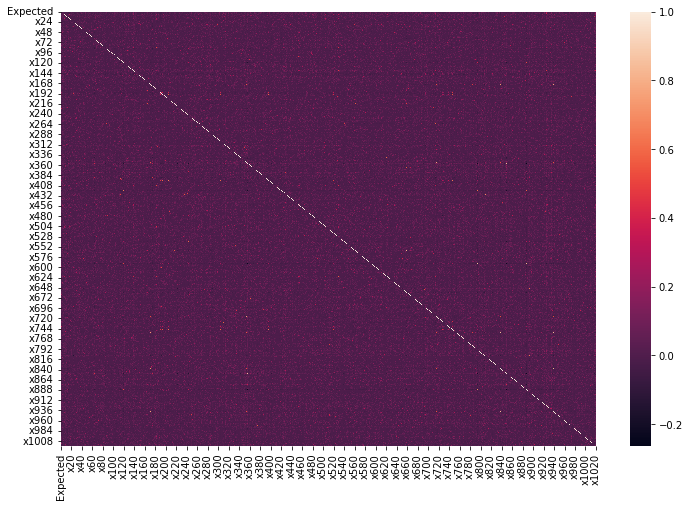

In [ ]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(a1[a1.columns[:1024]].corr(), ax=ax)
plt.show()

In [ ]:
corr = abs(a1.corr()[["Expected"]])
corr

,Expected
Expected,1.000000
x1,0.016673
x2,0.009353
x3,0.026250
x4,0.023761
...,...
fr_thiazole,0.014118
fr_thiocyan,0.005409
fr_thiophene,0.041870
fr_unbrch_alkane,0.010897


In [ ]:
new_cols = corr.sort_values('Expected', ascending=False).head(50).index.to_list()
new_cols.remove('Expected')

In [ ]:
def quick_model_test2(df, cols):
  df = df.dropna()
  X = df[cols]
  y = df['Expected']
  cv = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

  X_scaled = StandardScaler().fit_transform(X)
  # model = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1, max_iter=1000)
  model = RandomForestClassifier(n_estimators=500)
  y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
  model.fit(X_scaled, y)
  print("F1 score: ", f1_score(y, y_pred))
  print("Accuracy: ", accuracy_score(y, y_pred))
  return model

In [ ]:
quick_model_test2(a1, new_cols)

F1 score:  0.0
Accuracy:  0.9836477987421384


RandomForestClassifier(n_estimators=500)

In [ ]:
counter = 4
best_features2 = []
a2 = a1.dropna()

while (counter<=494):
  lr = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42, n_jobs=-1, max_iter=500)
  lr.fit(a2[best_features[counter:counter+15]], a2['Expected'])

  sf = SFS(lr, k_features='best', forward=False, n_jobs=-1)
  sf.fit(a2[best_features[counter:counter+15]], a2['Expected'])

  best_features2.append(list(sf.k_feature_names_))
  print(best_features2[-1:])
  counter += 15

[['x46', 'x74']]
[['x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x98', 'x99', 'x100', 'x101', 'x102', 'x104', 'x106']]
[['x110', 'x111', 'x112', 'x119', 'x120', 'x121', 'x124', 'x125', 'x127', 'x130', 'x133', 'x134']]
[['x144', 'x147', 'x149', 'x150', 'x151', 'x152', 'x153', 'x154', 'x155', 'x157']]
[['x198', 'x201', 'x206', 'x210']]
[['x233', 'x264']]
[['x271', 'x273', 'x274', 'x276', 'x278', 'x283', 'x289']]
[['x305', 'x308', 'x309', 'x310', 'x315', 'x318', 'x325', 'x328', 'x330', 'x332', 'x333', 'x336', 'x337', 'x339']]
[['x340', 'x344', 'x346', 'x348', 'x349', 'x352', 'x353', 'x354', 'x355', 'x359', 'x367']]
[['x369', 'x372', 'x376', 'x377', 'x385', 'x405', 'x408', 'x410']]
[['x411', 'x415', 'x422', 'x435', 'x440', 'x441']]
[['x446', 'x456', 'x461', 'x475', 'x480']]
[['x501', 'x515', 'x521', 'x535', 'x544']]
[['x556', 'x559', 'x560', 'x561', 'x570', 'x571', 'x575', 'x577', 'x578', 'x586']]
[['x595', 'x596', 'x601', 'x616', 'x618', 'x625']]
[['x633', 'x635', 'x636', 'x637', 'x63

In [ ]:
best_features = ['x10','x15','x20','x25','x31','x39','x41','x42','x44','x46','x60','x64','x74','x76','x77','x82','x83','x84','x88','x90','x91','x92','x93','x94','x95','x96','x98','x99','x100','x101','x102','x104','x106','x107','x110','x111','x112','x119','x120','x121','x124','x125','x127','x130','x131','x133','x134','x137','x139','x140','x144','x147','x149','x150','x151','x152','x153','x154','x155','x157','x158','x165','x168','x171','x180','x188','x197','x198','x199','x201','x202','x206','x207','x209','x210','x211','x213','x214','x216','x218','x221','x222','x224','x233','x236','x243','x244','x247','x248','x249','x253','x257','x262','x264','x271','x273','x274','x276','x278','x280','x281','x283','x287','x288','x289','x291','x292','x299','x301','x305','x308','x309','x310','x315','x318','x325','x328','x329','x330','x332','x333','x336','x337','x339','x340','x342','x344','x346','x348','x349','x352','x353','x354','x355','x359','x361','x362','x363','x367','x369','x371','x372','x376','x377','x378','x385','x389','x391','x392','x399','x404','x405','x408','x410','x411','x412','x413','x414','x415','x416','x420','x422','x435','x436','x438','x439','x440','x441','x443','x446','x447','x456','x459','x461','x466','x468','x471','x472','x475','x480','x481','x490','x493','x496','x501','x505','x511','x515','x517','x518','x521','x526','x527','x528','x535','x544','x545','x551','x552','x556','x559','x560','x561','x570','x571','x572','x575','x577','x578','x586','x587','x589','x590','x591','x595','x596','x597','x599','x601','x605','x609','x614','x616','x617','x618','x619','x620','x621','x625','x633','x634','x635','x636','x637','x638','x639','x643','x644','x646','x648','x649','x651','x652','x653','x655','x656','x658','x659','x661','x662','x663','x670','x671','x672','x678','x679','x688','x689','x692','x694','x708','x717','x725','x729','x736','x737','x743','x744','x751','x752','x753','x754','x756','x757','x758','x760','x761','x764','x766','x767','x769','x770','x771','x775','x780','x782','x788','x790','x797','x798','x799','x813','x815','x816','x818','x819','x820','x821','x823','x824','x831','x833','x834','x835','x839','x848','x854','x857','x859','x861','x862','x863','x864','x871','x873','x874','x875','x877','x878','x886','x890','x892','x893','x895','x896','x901','x903','x904','x907','x908','x909','x916','x917','x919','x920','x921','x923','x924','x928','x931','x932','x933','x934','x935','x936','x938','x939','x940','x942','x944','x945','x946','x951','x952','x954','x955','x957','x960','x961','x963','x966','x967','x968','x975','x976','x978','x980','x989','x992','x993','x994','x995','x996','x1001','x1002','x1004','x1015','x1020','x1022','x1023','x1024','MaxEStateIndex','MinEStateIndex','MaxAbsEStateIndex','MinAbsEStateIndex','MolWt','HeavyAtomMolWt','ExactMolWt','NumRadicalElectrons','MaxPartialCharge','BCUT2D_CHGHI','BCUT2D_MRHI','BalabanJ','BertzCT','Chi0','Chi0v','Chi1n','Chi1v','Chi2v','Chi4v','Kappa1','Kappa2','Kappa3','LabuteASA','PEOE_VSA1','PEOE_VSA10','PEOE_VSA12','PEOE_VSA13','PEOE_VSA14','PEOE_VSA2','PEOE_VSA4','PEOE_VSA5','PEOE_VSA7','PEOE_VSA8','PEOE_VSA9','SMR_VSA3','SMR_VSA4','SMR_VSA7','SMR_VSA8','SMR_VSA9','SlogP_VSA1','SlogP_VSA10','SlogP_VSA11','SlogP_VSA2','SlogP_VSA3','SlogP_VSA5','SlogP_VSA6','SlogP_VSA7','SlogP_VSA8','SlogP_VSA9','TPSA','EState_VSA1','EState_VSA11','EState_VSA2','EState_VSA4','EState_VSA5','EState_VSA7','EState_VSA9','VSA_EState1','VSA_EState10','VSA_EState2','VSA_EState3','VSA_EState4','VSA_EState5','VSA_EState6','VSA_EState7','VSA_EState8','VSA_EState9','FractionCSP3','HeavyAtomCount','NHOHCount','NOCount','NumAliphaticCarbocycles','NumAliphaticHeterocycles','NumAliphaticRings','NumAromaticCarbocycles','NumAromaticHeterocycles','NumAromaticRings','NumHDonors','NumHeteroatoms','NumSaturatedCarbocycles','RingCount','fr_Ar_N','fr_Ndealkylation2','fr_aldehyde','fr_alkyl_carbamate','fr_alkyl_halide','fr_amide','fr_amidine','fr_aniline','fr_azide','fr_azo','fr_barbitur','fr_benzodiazepine','fr_diazo','fr_dihydropyridine','fr_epoxide','fr_hdrzine','fr_hdrzone','fr_imide','fr_isocyan','fr_isothiocyan','fr_ketone','fr_ketone_Topliss','fr_nitrile','fr_nitro','fr_phenol_noOrthoHbond','fr_phos_ester','fr_piperdine','fr_priamide','fr_prisulfonamd','fr_quatN','fr_sulfonamd','fr_unbrch_alkane']
best_features2 = list(np.concatenate(best_features2))


In [ ]:
len(best_features2)

282

In [ ]:
features = list(sf.k_feature_names_)
features

['MinEStateIndex',
 'MinAbsEStateIndex',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_CHGHI']

In [ ]:
quick_model_test2(a2, best_features2)

F1 score:  0.0
Accuracy:  0.9836477987421384


RandomForestClassifier(n_estimators=500)

In [ ]:
a2

,Id,Expected,SMILES,assay,x1,x2,x3,x4,x5,x6,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
51,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;2452,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,CCCCCCCCC(=O)C;2452,2,CCCCCCCCC(C)=O,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
179,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];2452,2,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
248,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;2452,2,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,CCCSP(=O)(OCC)SCCC;2452,2,CCCSP(=O)(OCC)SCCC,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75293,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3...,2,Cl.Cl.O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
75304,C1=CC=C(C(=C1)C(=O)O)NC2=CC=CC(=C2)C(F)(F)F;2452,2,O=C(O)c1ccccc1Nc1cccc(C(F)(F)F)c1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75319,CC1=CC(=C(N1)/C=C\2/C3=CC=CC=C3NC2=O)C;2452,1,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75338,CCOC(=O)CCN(C(C)C)SN(C)C(=O)OC1=CC=CC2=C1OC(C2...,2,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_processedV, selector = feature_selector_pipeline.fit_transform(df_processed)
df_processedV

,Id,Expected,assay,SMILES,x2,x34,x65,x81,x115,x129,...,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
0,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1644,2,1644,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
1,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1630,2,1630,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
2,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;29,2,29,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
3,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1618,2,1618,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
4,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1638,2,1638,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75372,C1=CC=C(C=C1)NC(=S)N;1852,1,1852,NC(=S)Nc1ccccc1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
75373,CN1CN(CN(C1)C)C;2,2,2,CN1CN(C)CN(C)C1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75374,CCCCC1CCC(=O)O1;1852,1,1852,CCCCC1CCC(=O)O1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
75375,CCOC(=O)CCC1=CC=CC=C1;2,2,2,CCOC(=O)CCc1ccccc1,0,1,1,1,0,0,...,1,0,1,1,0,0,0,0,0,0


In [ ]:
for i in df_processedV.columns:
  print(i)

Id
Expected
assay
SMILES
x2
x34
x65
x81
x115
x129
x176
x295
x357
x379
x390
x562
x651
x660
x696
x727
x808
x850
x876
x894
x927
x936
MaxEStateIndex
MinEStateIndex
MaxAbsEStateIndex
MinAbsEStateIndex
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_MRHI
BCUT2D_MRLOW
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Ipc
Kappa1
Kappa2
Kappa3
LabuteASA
PEOE_VSA1
PEOE_VSA10
PEOE_VSA11
PEOE_VSA12
PEOE_VSA13
PEOE_VSA14
PEOE_VSA2
PEOE_VSA3
PEOE_VSA4
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
PEOE_VSA8
PEOE_VSA9
SMR_VSA1
SMR_VSA10
SMR_VSA2
SMR_VSA3
SMR_VSA4
SMR_VSA5
SMR_VSA6
SMR_VSA7
SMR_VSA9
SlogP_VSA1
SlogP_VSA10
SlogP_VSA11
SlogP_VSA12
SlogP_VSA2
SlogP_VSA3
SlogP_VSA4
SlogP_VSA5
SlogP_VSA6
SlogP_VSA7
SlogP_VSA8
TPSA
EState_VSA1
EState_VSA10
EState_VSA11
EState_VSA2
EState_VSA3
EState_VSA4
EState_VSA5
EState_VSA6
EState_VSA7
EState_VSA8
EState_VSA9
VSA_EState1
VSA_EState10
VSA_EState2
VSA_E

In [ ]:
df_processedV.groupby(['Expected', 'assay']).count()

Id  SMILES   x2  x34  x65  x81  x115  x129  x176  x295  ...  \
Expected assay                                                           ...   
1        11      23      23   23   23   23   23    23    23    23    23  ...   
         1372   110     110  110  110  110  110   110   110   110   110  ...   
         1373   121     121  121  121  121  121   121   121   121   121  ...   
         1374   110     110  110  110  110  110   110   110   110   110  ...   
         1375    68      68   68   68   68   68    68    68    68    68  ...   
...             ...     ...  ...  ...  ...  ...   ...   ...   ...   ...  ...   
2        5      255     255  255  255  255  255   255   255   255   255  ...   
         6      283     283  283  283  283  283   283   283   283   283  ...   
         7      262     262  262  262  262  262   262   262   262   262  ...   
         8      267     267  267  267  267  267   267   267   267   267  ...   
         9      257     257  257  257  257  257   257   257   257   257  ...   

                fr_benzene  fr_bicyclic  fr_ester  fr_ether  fr_halogen  \
Expected assay                                                            
1        11             23           23        23        23          23   
         1372          110          110       110       110         110   
         1373          121          121       121       121         121   
         1374          110          110       110       110         110   
         1375           68           68        68        68          68   
...                    ...          ...       ...       ...         ...   
2        5             255          255       255       255         255   
         6             283          283       283       283         283   
         7             262          262       262       262         262   
         8             267          267       267       267         267   
         9             257          257       257       257         257   

                fr_methoxy  fr_para_hydroxylation  fr_phenol  \
Expected assay                                                 
1        11             23                     23         23   
         1372          110                    110        110   
         1373          121                    121        121   
         1374          110                    110        110   
         1375           68                     68         68   
...                    ...                    ...        ...   
2        5             255                    255        255   
         6             283                    283        283   
         7             262                    262        262   
         8             267                    267        267   
         9             257                    257        257   

                fr_phenol_noOrthoHbond  fr_unbrch_alkane  
Expected assay                                            
1        11                         23                23  
         1372                      110               110  
         1373                      121               121  
         1374                      110               110  
         1375                       68                68  
...                                ...               ...  
2        5                         255               255  
         6                         283               283  
         7                         262               262  
         8                         267               267  
         9                         257               257  

[278 rows x 156 columns]

In [ ]:
df_processedV.loc[df_processedV['Expected'] == 1].groupby("assay").count().sort_values("Id")

,Id,Expected,SMILES,x2,x34,x65,x81,x115,x129,x176,...,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
assay,,,,,,,,,,,,,,,,,,,,,
1622,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1646,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1611,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1635,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,434,434,434,434,434,434,434,434,434,434,...,434,434,434,434,434,434,434,434,434,434
1850,514,514,514,514,514,514,514,514,514,514,...,514,514,514,514,514,514,514,514,514,514
1857,597,597,597,597,597,597,597,597,597,597,...,597,597,597,597,597,597,597,597,597,597


In [ ]:
currentassay = 1857
test = df_processed.loc[df_processedV['assay'] == str(currentassay)]


In [ ]:
test.groupby('Expected').count()

,Id,SMILES,assay,x1,x2,x3,x4,x5,x6,x7,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
Expected,,,,,,,,,,,,,,,,,,,,,
1,597,597,597,597,597,597,597,597,597,597,...,597,597,597,597,597,597,597,597,597,597
2,944,944,944,944,944,944,944,944,944,944,...,944,944,944,944,944,944,944,944,944,944


In [ ]:
vtr = VarianceThresh()
testV, selector = vtr.fit_transform(test)
testV

,Id,Expected,assay,SMILES,x2,x34,x65,x81,x148,x176,...,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
32,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1857,1,1857,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,0,1,...,0,2,0,0,0,3,0,2,2,0
146,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];1857,1,1857,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,12
249,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;1857,2,1857,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
289,[Na+].[I-];1857,2,1857,[I-].[Na+],0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
358,CCCSP(=O)(OCC)SCCC;1857,1,1857,CCCSP(=O)(OCC)SCCC,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74763,C(NC(=O)NC1C(=O)NC(=O)N1CO)NC(=O)NC2C(=O)NC(=O...,2,1857,O=C(NCNC(=O)NC1C(=O)NC(=O)N1CO)NC1C(=O)NC(=O)N1CO,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
74794,CC(C)(C1=CC(=C(C=C1)O)C2=CC=CC=C2)C3=CC(=C(C=C...,2,1857,CC(C)(c1ccc(O)c(-c2ccccc2)c1)c1ccc(O)c(-c2cccc...,0,1,1,0,0,1,...,0,4,0,0,0,0,0,2,2,0
74889,CC1=NN(C(=O)C1N=NC2=CC=CC=C2)C3=C(C=CC(=C3)S(=...,2,1857,CC1=NN(c2cc(S(=O)(=O)[O-])ccc2Cl)C(=O)C1N=Nc1c...,0,1,1,0,0,1,...,0,2,0,0,0,1,0,0,0,0
74982,C1CCC(C1)O;1857,1,1857,OC1CCCC1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
X = testV.drop(columns=['Id', 'Expected','assay', "SMILES"])
n_scores = cross_val_score(model, X, testV['Expected'], scoring="f1", cv=cv, n_jobs=-1)
# report performance
print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1: 0.657 (0.021)


In [ ]:
d = FileReadTransform()
can = CanonicalGenerator()
f = FingerprintGenerator()

df = d.fit_transform(df)
df = can.fit_transform(df)
df = f.fit_transform(df)

test = df.loc[df['assay'] == str(currentassay)]
test

FileReadTransform done
CanonicalGenerator done
FingerprintGenerator done


,Id,Expected,SMILES,assay,x1,x2,x3,x4,x5,x6,...,x1015,x1016,x1017,x1018,x1019,x1020,x1021,x1022,x1023,x1024
32,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1857,1,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1857,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];1857,1,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],1857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;1857,2,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,1857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,[Na+].[I-];1857,2,[I-].[Na+],1857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
358,CCCSP(=O)(OCC)SCCC;1857,1,CCCSP(=O)(OCC)SCCC,1857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74763,C(NC(=O)NC1C(=O)NC(=O)N1CO)NC(=O)NC2C(=O)NC(=O...,2,O=C(NCNC(=O)NC1C(=O)NC(=O)N1CO)NC1C(=O)NC(=O)N1CO,1857,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
74794,CC(C)(C1=CC(=C(C=C1)O)C2=CC=CC=C2)C3=CC(=C(C=C...,2,CC(C)(c1ccc(O)c(-c2ccccc2)c1)c1ccc(O)c(-c2cccc...,1857,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74889,CC1=NN(C(=O)C1N=NC2=CC=CC=C2)C3=C(C=CC(=C3)S(=...,2,CC1=NN(c2cc(S(=O)(=O)[O-])ccc2Cl)C(=O)C1N=Nc1c...,1857,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
74982,C1CCC(C1)O;1857,1,OC1CCCC1,1857,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,'SR-HSE','SR-MMP','SR-p53'

In [ ]:
df_processed[['aromatase']]

KeyError: ignored

In [ ]:
vtr = VarianceThresh()
testV, selector = vtr.fit_transform(test)
testV

,Id,Expected,assay,SMILES,x2,x34,x65,x81,x148,x176,...,x357,x390,x651,x696,x727,x808,x850,x876,x894,x927
32,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;1857,1,1857,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,1,0,0,0,0,1,...,1,0,0,0,1,1,1,0,0,0
146,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];1857,1,1857,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
249,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;1857,2,1857,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,0,1
289,[Na+].[I-];1857,2,1857,[I-].[Na+],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
358,CCCSP(=O)(OCC)SCCC;1857,1,1857,CCCSP(=O)(OCC)SCCC,0,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74763,C(NC(=O)NC1C(=O)NC(=O)N1CO)NC(=O)NC2C(=O)NC(=O...,2,1857,O=C(NCNC(=O)NC1C(=O)NC(=O)N1CO)NC1C(=O)NC(=O)N1CO,0,0,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
74794,CC(C)(C1=CC(=C(C=C1)O)C2=CC=CC=C2)C3=CC(=C(C=C...,2,1857,CC(C)(c1ccc(O)c(-c2ccccc2)c1)c1ccc(O)c(-c2cccc...,0,1,1,0,0,1,...,1,1,0,0,1,1,1,1,0,0
74889,CC1=NN(C(=O)C1N=NC2=CC=CC=C2)C3=C(C=CC(=C3)S(=...,2,1857,CC1=NN(c2cc(S(=O)(=O)[O-])ccc2Cl)C(=O)C1N=Nc1c...,0,1,1,0,0,1,...,1,1,1,0,1,0,1,1,0,0
74982,C1CCC(C1)O;1857,1,1857,OC1CCCC1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
best_features2.insert(0, 'assay')

In [ ]:
len(best_features2)

283

In [ ]:
a2V, selector = vtr.fit_transform(a2)
a2V

,Id,Expected,assay,SMILES,x34,x65,x81,x148,x176,x295,...,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
51,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;2452,2,2452,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,0,0,0,0,1,0,...,2,0,0,0,3,0,0,2,2,0
126,CCCCCCCCC(=O)C;2452,2,2452,CCCCCCCCC(C)=O,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,4
179,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];2452,2,2452,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,12
248,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;2452,2,2452,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
334,CCCSP(=O)(OCC)SCCC;2452,2,2452,CCCSP(=O)(OCC)SCCC,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75293,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3...,2,2452,Cl.Cl.O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,0,1,1,0,1,0,...,2,0,0,1,3,0,0,0,0,1
75304,C1=CC=C(C(=C1)C(=O)O)NC2=CC=CC(=C2)C(F)(F)F;2452,2,2452,O=C(O)c1ccccc1Nc1cccc(C(F)(F)F)c1,0,1,0,0,1,0,...,2,0,0,0,3,0,1,0,0,0
75319,CC1=CC(=C(N1)/C=C\2/C3=CC=CC=C3NC2=O)C;2452,1,2452,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,1,1,0,0,1,0,...,1,1,0,0,0,0,1,0,0,0
75338,CCOC(=O)CCN(C(C)C)SN(C)C(=O)OC1=CC=CC2=C1OC(C2...,2,2452,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,1,1,1,1,0,1,...,1,1,1,3,0,0,1,0,0,0


In [ ]:
model = model = KNeighborsClassifier(n_neighbors=5)
scaler = StandardScaler()
scaled = scaler.fit_transform(a2.drop(columns=['Id', 'assay', 'SMILES', 'Expected']))

X_train, X_test, y_train, y_test = train_test_split(scaled, a2["Expected"].values, test_size=0.1, random_state=5)

model.fit(X_train, y_train)

y_predRF = model.predict(X_test)
   
print(f"model: {model} Accuracy: {accuracy_score(y_test, y_predRF)} F1 Score: {f1_score(y_test, y_predRF, zero_division=1)}")

model: KNeighborsClassifier() Accuracy: 0.9874213836477987 F1 Score: 0.0


In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(a2V.drop(columns=['Id', 'assay', 'SMILES', 'Expected']))
anomaly = IsolationForest(n_estimators=200, contamination=0.1)
anomaly.fit(scaled)

IsolationForest(contamination=0.1, n_estimators=200)

In [ ]:
outliers = anomaly.predict(scaled)

In [ ]:
# [x for x in outliers if x>0.5]

In [ ]:
checker = []
for i in range(len(outliers)):
  if outliers[i] != 1:  
    checker.append(i)

In [ ]:
a2.iloc[checker]

,Id,Expected,SMILES,assay,x1,x2,x3,x4,x5,x6,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
470,C(C(C(C(C(F)(F)S(=O)(=O)O)(F)F)(F)F)(F)F)(C(C(...,2,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2312,C1[C@@H]2[C@H](COS(=O)O1)[C@@]3(C(=C([C@]2(C3(...,2,O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4825,CN(C)C1=CC=C(C=C1)C(=C2C=CC(=[N+](C)C)C=C2)C3=...,2,CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccc(N(C)...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5440,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,2,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CC...,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6576,CO/C=C(\C1=CC=CC=C1OC2=NC=NC(=C2)OC3=CC=CC=C3C...,2,CO/C=C(/C(=O)OC)c1ccccc1Oc1cc(Oc2ccccc2C#N)ncn1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74993,CCCCCCCCCCCCOS(=O)(=O)O.CC[C@@H]1[C@@]([C@@H](...,2,CCC(=O)O[C@H]1[C@H](O[C@@H]2[C@@H](C)[C@H](O[C...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0
75021,CCOC1=NC2=CC=CC(=C2N1CC3=CC=C(C=C3)C4=CC=CC=C4...,2,CCOc1nc2cccc(C(=O)OC(C)OC(=O)OC3CCCCC3)c2n1Cc1...,2452,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
75038,CC(C)(C)C1=CC=C(C=C1)S(=O)(=O)NC2=C(C(=NC(=N2)...,2,COc1ccccc1Oc1c(NS(=O)(=O)c2ccc(C(C)(C)C)cc2)nc...,2452,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
75178,CC(C)C(CCCN(C)CCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC...,2,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,2452,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
a2.iloc[checker].loc[a2['Expected'] == 1]

,Id,Expected,SMILES,assay,x1,x2,x3,x4,x5,x6,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
12829,CCN1CCC2(CC1)COC3=C2C=C4C(=C3)CCN4C(=O)C5=CC=C...,1,CCN1CCC2(CC1)COc1cc3c(cc12)N(C(=O)c1ccc(-c2ccc...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24001,CCOC(=O)O[C@H](C)OC(=O)C1=CC2=C(C=C1)N(C(=C2)C...,1,CCOC(=O)O[C@H](C)OC(=O)c1ccc2c(c1)cc(C(=O)NC1C...,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28892,CC1=CC(=CC2=C1NC(=O)CC2(C)C)CCN3CCN(CC3)C4=NSC...,1,CS(=O)(=O)O.Cc1cc(CCN2CCN(c3nsc4ccccc34)CC2)cc...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55300,C1=CC(=CC=C1N/C(=N/C(=NCCCCCCN=C(/N=C(/NC2=CC=...,1,NC(=NCCCCCCN=C(N)/N=C(\N)Nc1ccc(Cl)cc1)/N=C(\N...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
71439,CCNC1=CC2=C(C=C1C)C(=C3C=C(C(=[NH+]CC)C=C3O2)C...,1,CCNc1cc2oc3cc(=[NH+]CC)c(C)cc-3c(-c3ccccc3C(=O...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72167,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,1,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72812,CCCCCCCCCCCCCCCC[N+]1=CC=CC=C1.[Br-];2452,1,CCCCCCCCCCCCCCCC[n+]1ccccc1.[Br-],2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
73050,C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(C4=CC=C(C=C4)...,1,O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc...,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73975,CN(C)CCOC1=CC=C(C=C1)/C(=C(/CCCl)\C2=CC=CC=C2)...,1,CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc...,2452,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
a2.groupby("Expected").count()

,Id,Expected,SMILES,assay,x1,x2,x3,x4,x5,x6,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
51,C1=CC(=CC=C1C(C2=CC=C(C=C2)O)C(Cl)(Cl)Cl)O;2452,2,Oc1ccc(C(c2ccc(O)cc2)C(Cl)(Cl)Cl)cc1,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,CCCCCCCCC(=O)C;2452,2,CCCCCCCCC(C)=O,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
179,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-];2452,2,CCCCCCCCCC[N+](C)(C)CCCCCCCCCC.[Cl-],2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0
248,C1CN(C(=N1)N[N+](=O)[O-])CC2=CN=C(C=C2)Cl;2452,2,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334,CCCSP(=O)(OCC)SCCC;2452,2,CCCSP(=O)(OCC)SCCC,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75293,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3...,2,Cl.Cl.O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
75304,C1=CC=C(C(=C1)C(=O)O)NC2=CC=CC(=C2)C(F)(F)F;2452,2,O=C(O)c1ccccc1Nc1cccc(C(F)(F)F)c1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75319,CC1=CC(=C(N1)/C=C\2/C3=CC=CC=C3NC2=O)C;2452,1,Cc1cc(C)c(/C=C2\C(=O)Nc3ccccc32)[nH]1,2452,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75338,CCOC(=O)CCN(C(C)C)SN(C)C(=O)OC1=CC=CC2=C1OC(C2...,2,CCOC(=O)CCN(SN(C)C(=O)Oc1cccc2c1OC(C)(C)C2)C(C)C,2452,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
25 / 1590

0.015723270440251572

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(a2[best_features2])
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(scaled)
preds = kmeans.predict(scaled)
preds

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
checker = []
for i in range(len(preds)):
  if preds[i] != 1:  
    checker.append(i)

a2.iloc[checker]['Expected'].value_counts()

2    1075
1       9
Name: Expected, dtype: int64

In [ ]:
# model = HistGradientBoostingClassifier()
# # define the evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# X = df_processed.drop(columns=['Id', 'Expected', "SMILES"])
# n_scores = cross_val_score(model, X, df_processed['Expected'], scoring="f1", cv=cv, n_jobs=-1)
# # report performance
# print('F1: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df_fp.drop(columns=['Expected', "Id", "SMILES"]), df_fp["Expected"].values, test_size=0.3, stratify=df_fp['Expected'],random_state=5)

# # RFmodel = RandomForestClassifier(n_estimators=500, random_state=1, max_depth=7, )
# # RFmodel.fit(X_train, y_train)
# # y_predRF = RFmodel.predict(X_test)

# KNN = KNeighborsClassifier()
# KNN.fit(X_train, y_train)
# y_predRF = KNN.predict(X_test)

# # from sklearn.linear_model import SGDClassifier
# # lr = SGDClassifier(loss='perceptron', random_state=5)
# # lr.fit(X_train, y_train)

# # lr_params = {'alpha' : [10**(-x) for x in range(7)],
# #              'penalty' : ['l1', 'l2', 'elasticnet'],
# #              'l1_ratio' : [0.15, 0.25, 0.5, 0.75]}

# # y_predRF = lr.predict(X_train)

# # Print the accuracy score
# print(accuracy_score(y_test, y_predRF))
# print(f1_score(y_test, y_predRF, zero_division=0))

In [ ]:
# # Id = X['x'].values

# #Switch off the line below when using training data
# X = df_fp.drop(["Expected", "Id", "SMILES"], axis=1)

# #Switch off the line below when using testing data
# # X = df_fp.drop(["x", "SMILES"], axis=1)

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit the scaler to the data
# scaler.fit(X)

# # Scale the data
# X_scaled = scaler.transform(X)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_fp["Expected"].values, test_size=0.3, stratify=df_fp['Expected'],random_state=5)

# # RFmodel = RandomForestClassifier(n_estimators=500, random_state=1, max_depth=7, )
# # RFmodel.fit(X_train, y_train)
# # y_predRF = RFmodel.predict(X_test)

# hgbm = HistGradientBoostingClassifier(random_state=42)
# hgbm.fit(X_train, y_train)
# hgbm.score(X_test, y_test)


# print(accuracy_score(y_test, y_predRF))
# print(f1_score(y_test, y_predRF, zero_division=0))

In [ ]:
# y_predRF = hgbm.predict(X_test)
# print(f1_score(y_test, y_predRF, zero_division=0))